# 0.0. Imports

In [2]:
# import the relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import inflection
import math
import seaborn as sns
sns.set()
import xgboost as xgb

from IPython.display       import Image
from scipy                 import stats
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from boruta                import BorutaPy
from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso

## 0.1. Helper Functions

In [3]:
# Cramer V function - Applied on 4.3.2. Categorical Attributes
def cramer_v( x, y ):
    # confusion matrix
    cm = pd.crosstab( x, y ).to_numpy()
    # number of observations
    n = cm.sum()
    # number of rows (r) and columns (k)
    r, k = cm.shape
    # chi2, only value from [0] is needed for the formula.
    chi2 = stats.chi2_contingency( cm )[0]
    # chi2 correction
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1))
    # k correction
    kcorr = k - (k-1)**2/(n-1)
    # r correction
    rcorr = r - (r-1)**2/(n-1)
    
    # return cramer v formula result
    return np.sqrt( (chi2corr/n) / ( min(kcorr-1, rcorr-1) ) )

In [4]:
# Error, performance calculation - applied on 7.0. Machine Learning Modelling

def mean_absolute_percentage_error(y, yhat):
    return np.mean( np.abs( (y - yhat) / y ) )

# mape - mean absolute percentage error
def ml_error(model_name, y, yhat):
    mae = mean_absolute_error( y, yhat ) # mae - mean absolute error
    rmse = np.sqrt( mean_squared_error( y, yhat ) ) # rmse - root mean square error
    mape = mean_absolute_percentage_error( y, yhat )
    
    return pd.DataFrame({'Model Name':model_name, 
                         'MAE':mae,
                         'MAPE':mape,
                         'RMSE':rmse}, index=[0])

# Cross-Validation function - applied on 7.0. Machine Learning Modelling
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    
    # errors list to concatenate the values
    mae_list = []
    mape_list = []
    rmse_list = []
    
    # Cross-validation k-fold
    # k-fold range reversed: from max to min.
    for k in reversed( range(1, kfold+1 ) ):
        if verbose:
            print('\nKFold Number: {}'.format(k))
        
        # start and end for date validation
        # subtract 6 weeks (6*7) from date max: first date of validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)
        
        # filter dataset for training and validation
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]
        
        # training dataset
        xtraining = training.drop(['date', 'customers'], axis=1)
        ytraining = training['customers']
        
        # validation dataset
        xvalidation = validation.drop(['date', 'customers'], axis=1)
        yvalidation = validation['customers']
        
        # apply the model
        model = model.fit(xtraining, ytraining)
        
        # prediction
        yhat = model.predict(xvalidation)
        
        # performance
        result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat) )
        
        # store performance of each k-fold iteration
        mae_list.append( result['MAE'] )
        mape_list.append( result['MAPE'])
        rmse_list.append( result['RMSE'])
        
    # mean and stabndard deviation of errors after cross-validation
    return pd.DataFrame({'Model Name': model_name,
                        'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + '+/-' + np.round( np.std( mae_list ), 2 ).astype (str),
                        'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype(str) + '+/-' + np.round( np.std( mape_list), 2 ).astype( str ),
                        'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + '+/-' + np.round( np.std( rmse_list ), 2 ).astype( str )},
                      index=[0])


## 0.2. Load Data

In [5]:
# load daily sales dataset
df_data_raw = pd.read_csv('C:/Users/santo/repos/DataScience-Em-Producao/data/train.csv', low_memory=False)

# load stores dataset
df_stores_raw = pd.read_csv('C:/Users/santo/repos/DataScience-Em-Producao/data/store.csv', low_memory=False)

In [3]:
df_data_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [4]:
df_data_raw.shape

(1017209, 9)

In [5]:
df_stores_raw.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [6]:
df_stores_raw.shape

(1115, 10)

In [6]:
# merge daily sales and stores dataset
df_raw = pd.merge(df_data_raw, df_stores_raw, on='Store', how='left')

In [8]:
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 1.0. Data Description

In [7]:
# copy original data
df1 = df_raw.copy()

## 1.1. Columns Description and Rename

In [10]:
# Select Columns
columns = df1.columns
columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [11]:
df_columns = pd.DataFrame({'Descripion':['a unique Id for each store', 'the day of the week', 'register date', 
                            'the turnover for any given day', 'the number of customers on a given day', 
                            'an indicator for whether the store was open: 0 = closed, 1 = open', 
                            'indicates whether a store is running a promo on that day', 
                            'indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None',
                            'indicates if the (Store, Date) was affected by the closure of public schools', 
                            'differentiates between 4 different store models: a, b, c, d', 
                            'describes an assortment level: a = basic, b = extra, c = extended', 
                            'distance in meters to the nearest competitor store', 
                            'gives the approximate month of the time the nearest competitor was opened',
                            'gives the approximate year of the time the nearest competitor was opened', 
                            'Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating',
                            'describes the calendar week when the store started participating in Promo2', 
                            'describes the year when the store started participating in Promo2', 
                            'describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store']},
                            index=[columns])

In [5]:
# display columns complete description
pd.set_option('display.max_colwidth', None)
df_columns

NameError: name 'df_columns' is not defined

In [8]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

# Apply snakecase to columns names
snakecase = lambda x: inflection.underscore( x )
cols = list(map(snakecase, cols_old))
df1.columns = cols

In [14]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2. Data Dimensions

In [15]:
# Check data dimensions
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 1017209
Number of columns: 18


In [16]:
# data dimensions dataframe
dimensions_df = pd.DataFrame({'Number of rows':[df1.shape[0]], 'Number of columns':[df1.shape[1]]})
dimensions_df

,Number of rows,Number of columns
0,1017209,18


In [17]:
# data dimensions series
dimensions_series = pd.Series([df1.shape[0], df1.shape[1]], index=['Number of rows', 'Number of columns'], name='dimensions')
dimensions_series

Number of rows       1017209
Number of columns         18
Name: dimensions, dtype: int64

## 1.3. Data Types

In [9]:
# check data types
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [10]:
# transform column date to datetime
df1['date'] = pd.to_datetime(df1['date'])

In [11]:
# check data types
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

In [8]:
# Check date general information
df1['date'].describe()

count                 1017209
unique                    942
top       2015-06-09 00:00:00
freq                     1115
first     2013-01-01 00:00:00
last      2015-07-31 00:00:00
Name: date, dtype: object

In [22]:
df1['date'].value_counts()

2015-06-09    1115
2013-07-22    1115
2015-04-25    1115
2014-04-12    1115
2013-03-30    1115
              ... 
2014-10-28     935
2014-10-20     935
2014-07-01     935
2014-12-08     935
2014-10-23     935
Name: date, Length: 942, dtype: int64

## 1.4. Check Missing Values

In [12]:
# check missing values
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout Missing Values

In [10]:
# Check competition distance
df1['competition_distance'].describe()

count    1.014567e+06
mean     5.430086e+03
std      7.715324e+03
min      2.000000e+01
25%      7.100000e+02
50%      2.330000e+03
75%      6.890000e+03
max      7.586000e+04
Name: competition_distance, dtype: float64

In [11]:
df1['competition_distance'].max()

75860.0

In [13]:
# competition_distance assumption: NA values mean a far competitor distance.
# therefore, the NA values will be replaced by 200000 (meters).
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan(x) else x)

In [14]:
# competition_open_since_month and competition_open_since_year
# Assumption: fill NA with the corresponding month and year of the register.
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

In [14]:
# Check promo2 info
aux1 = df1[(df1['promo2'] > 0)]
aux1['promo_interval'].isna().sum()

# Conclusion: all promo2_since_week, promo2_since_year and promo_interval have promo2 == 0.

0

In [15]:
# promo2_since_week, promo2_since_year assumption: fill NA with the corresponding month and year of the register.
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].isocalendar()[1] if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1)
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

In [16]:
# promo_interval - fill missing values with 0
df1['promo_interval'].fillna(0, inplace=True)

In [17]:
# check missing values
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
dtype: int64

## 1.6. Change Data Types

In [18]:
# check data types
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

In [19]:
# change data types from float64 to int64 in order to allow further operations
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

In [20]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
dtype: object

## 1.7. Descriptive Statistics

### 1.7.1. Numerical Attributes

In [110]:
# select numerical attributes
num_attributes = df1.select_dtypes( include=['float64', 'int64'])

In [36]:
# central tendency
ct1 = pd.DataFrame( num_attributes.apply( np.mean )).T
ct2 = pd.DataFrame( num_attributes.apply( np.median )).T

# dispersion - standard deviation (std), min, max
d1 = pd.DataFrame( num_attributes.apply(np.std)).T
d2 = pd.DataFrame( num_attributes.apply( min )).T
d3 = pd.DataFrame( num_attributes.apply( max )).T

# min max range
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min())).T

# dispersion - skew and kurtosis
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew())).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis())).T

# concatenate all data frames
df = pd.concat([d2, d3, d4, ct1, d1, ct2, d5, d6]).T.reset_index()
df.columns = ['attributes', 'min', 'max', 'range', 'mean', 'std', 'median', 'skew', 'kurtosis']

# display data frame
df

,attributes,min,max,range,mean,std,median,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,321.908493,558.0,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,1.997390,4.0,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,3849.924283,5744.0,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,464.411506,609.0,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,0.375539,1.0,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.485758,0.0,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.383056,0.0,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,12547.646829,2330.0,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,3.311085,7.0,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,5.515591,2012.0,-7.235657,124.071304


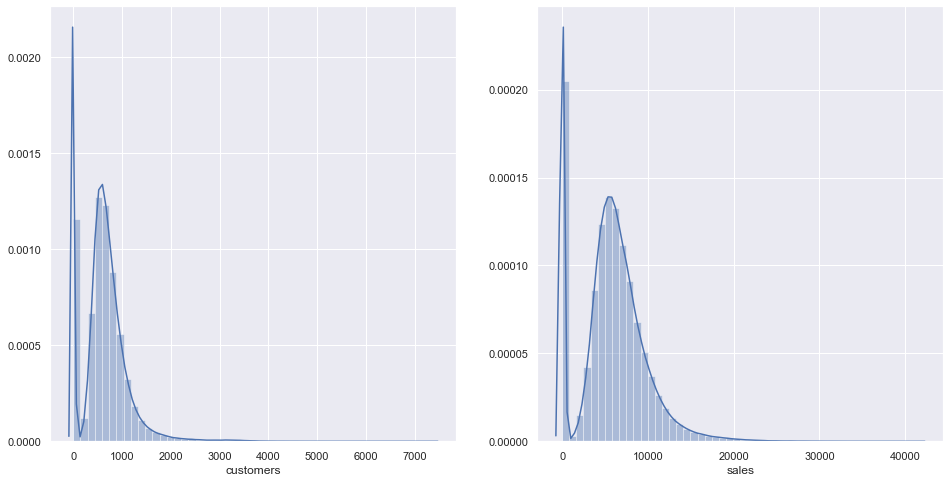

In [37]:
# plot customers and sales distribution

# set up figure size
f, ax = plt.subplots( 1, 2, figsize=(16,8))

# customers distribution
plt.subplot( 1, 2, 1)
sns.distplot(df1['customers'])

# sales distribution
plt.subplot( 1, 2, 2)
sns.distplot(df1['sales'])

In [38]:
# Dates general information
date_describe = df1['date'].describe()
date_describe

count                 1017209
unique                    942
top       2015-06-09 00:00:00
freq                     1115
first     2013-01-01 00:00:00
last      2015-07-31 00:00:00
Name: date, dtype: object

In [39]:
# higher sales values
df1['sales'].sort_values(ascending=False).head(10)

44393     41551
132946    38722
101726    38484
87231     38367
424086    38037
627776    38025
627220    37646
444361    37403
620531    37376
245945    37122
Name: sales, dtype: int64

In [40]:
# sales values describe
df1['sales'].describe()

count    1.017209e+06
mean     5.773819e+03
std      3.849926e+03
min      0.000000e+00
25%      3.727000e+03
50%      5.744000e+03
75%      7.856000e+03
max      4.155100e+04
Name: sales, dtype: float64

In [41]:
# higher customers values
df1['customers'].sort_values(ascending=False).head(10)

993496    7388
319810    5494
101726    5458
432096    5387
444361    5297
87231     5192
129601    5152
745411    5145
132946    5132
776631    5112
Name: customers, dtype: int64

In [42]:
# customers describe
df1['customers'].describe()

count    1.017209e+06
mean     6.331459e+02
std      4.644117e+02
min      0.000000e+00
25%      4.050000e+02
50%      6.090000e+02
75%      8.370000e+02
max      7.388000e+03
Name: customers, dtype: float64

In [43]:
# lower sales values with open stores
aux1 = df1[(df1['open']==1) ]
aux1['sales'].sort_values(ascending=True).head(10)

86825     0
561199    0
438426    0
817174    0
843969    0
142278    0
340860    0
347669    0
591147    0
386065    0
Name: sales, dtype: int64

In [44]:
# open stores with sales = 0
aux = df1[(df1['open']==1) & (df1['sales']==0)]
aux.shape[0]

54

In [45]:
# open stores with customers = 0
aux = df1[(df1['open']==1) & (df1['customers']==0)]
aux.shape[0]

52

In [46]:
# lower customer values with open stores
aux1 = df1[(df1['customers']>0) ]
aux1['customers'].sort_values(ascending=True).head(10)

478649     3
889932     5
273387     8
202712    13
846592    18
996161    36
941137    40
752014    44
487894    50
970922    60
Name: customers, dtype: int64

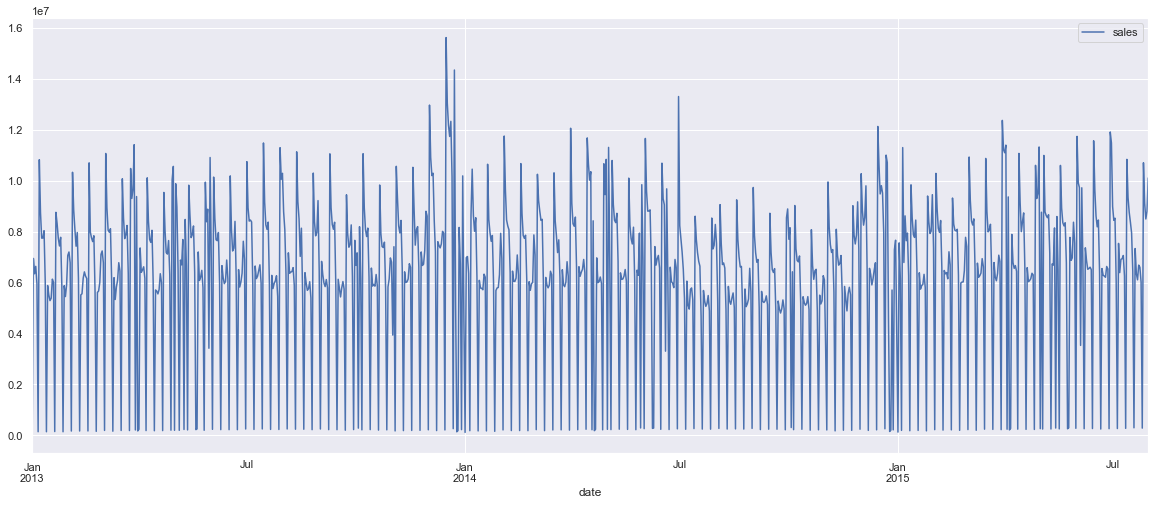

In [47]:
# plot sales by date
# sum of all sales by date
aux3 = df1[['date', 'sales']].groupby('date').sum().reset_index()
aux3 = aux3.set_index('date')
aux3.plot(figsize=(20,8))

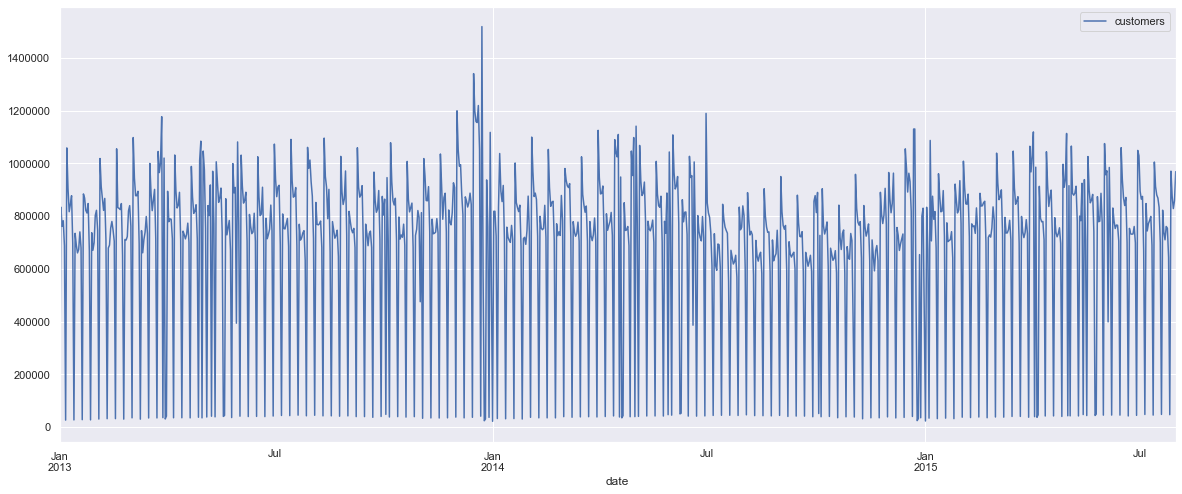

In [48]:
# plot customers by date
# sum of all customers by date
aux4 = df1[['date', 'customers']].groupby('date').sum().reset_index()
aux4 = aux4.set_index('date')
aux4.plot(figsize=(20,8))

### 1.7.2. Categorical Attributes

In [49]:
# select categorical attributes
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64'])
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval
0,0,c,a,0
1,0,a,a,"Jan,Apr,Jul,Oct"
2,0,a,a,"Jan,Apr,Jul,Oct"
3,0,c,c,0
4,0,a,a,0


In [50]:
# check categorical values
cat_attributes.apply( lambda x: x.unique().shape[0])

state_holiday     4
store_type        4
assortment        3
promo_interval    4
dtype: int64

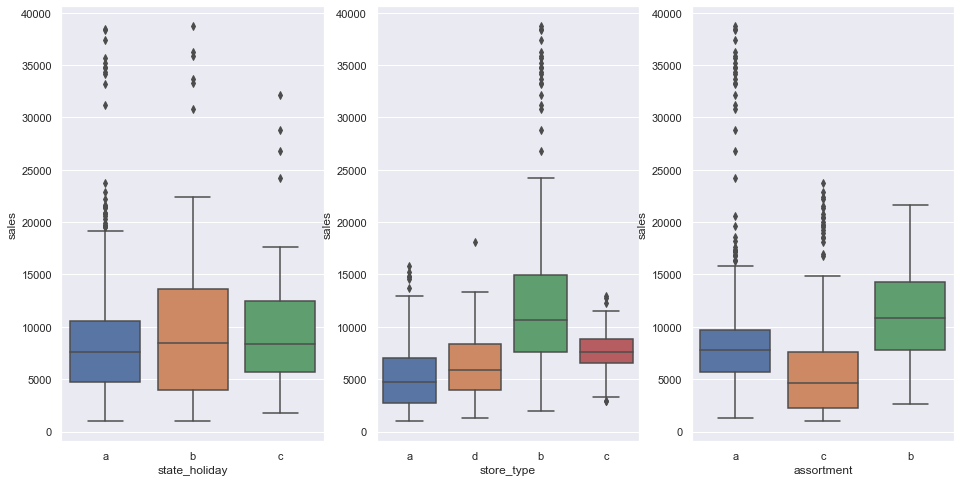

In [51]:
# apply filter to better off boxplot visualization: only holidays and sales higher than 0.
aux5 = df1[(df1['state_holiday'] != '0' ) & (df1['sales']>0 )]

# set up figure size
f, ax = plt.subplots( 1, 3, figsize=(16,8))

# boxplot state_holiday
plt.subplot( 1, 3, 1)
sns.boxplot( x='state_holiday', y='sales', data=aux5)

# boxplot store_type
plt.subplot( 1, 3, 2)
sns.boxplot( x='store_type', y='sales', data=aux5)

# boxplot assortment
plt.subplot( 1, 3, 3)
sns.boxplot( x='assortment', y='sales', data=aux5)

# 2.0. Feature Engineering

In [21]:
df2 = df1.copy()

## 2.1. Mind Map

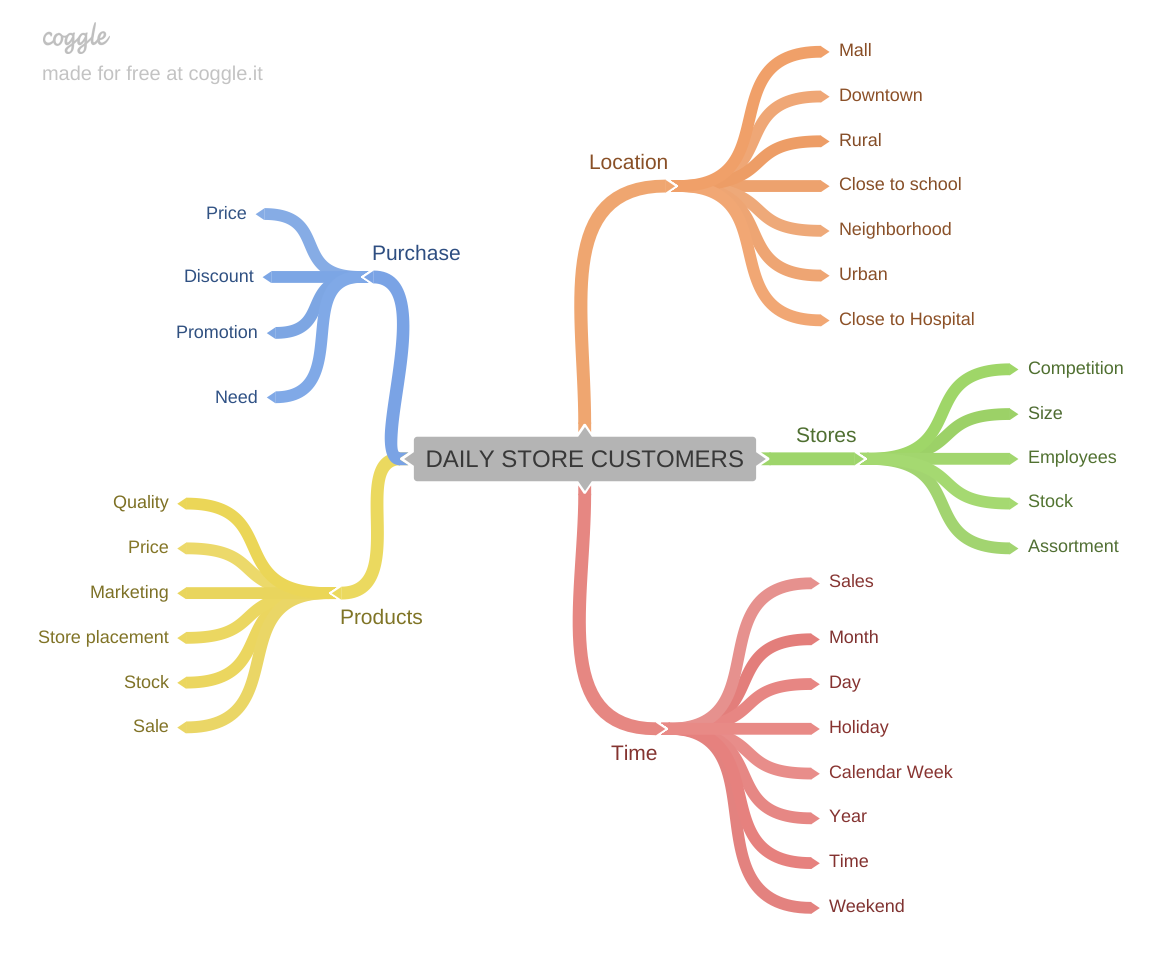

In [53]:
# Load Mind Map
Image('C:/Users/santo/repos/DataScience-Em-Producao/img/DAILY_STORE_CUSTOMERS.png')

## 2.2. Hypothesis Creation

### 2.2.1. Store Hypothesis

**1.** Stores with bigger staff (employees) should have more customers.

**2.** Stores with bigger Stock should have more customers.

**3.** Stores with bigger size should have more customers.

**4.** Stores with bigger Assortment should have more customers.

**5.** Stores with competition closer should have less customers.

**6.** Stores with longer time competition should have more customers.

### 2.2.2. Product Hypothesis

**1.** Stores that invest more on Marketing should have more customers.

**2.** Stores that expose more the products (Store Placement) should have more customers.

**3.** Stores with lower product prices should have more customers.

**4.** Stores with more agressive Sale (bigger discount) should have more customers.

**5.** Stores with longer Sale (promo) should have more customers.

**6.** Stores with more Sale (promo) days should have more customers.

**7.** Stores with more consecutive Sale (promo) should have more customers.

### 2.2.3. Time Hypothesis

**1.** Stores open on Christmas time should have more customers.

**2.** Stores should have more customers throughout the years.

**3.** Stores should have more customers between April and September.

**4.** Stores should have more customers after the 10th months day.

**5.** Stores should have more customers on weekend.

**6.** Stores should have less customers while school vacation.

## 2.3. Final Hypothesis List (Based on the data available in the original dataset)

**1.** Stores with bigger Assortment should have more customers.

**2.** Stores with competition closer should have less customers.

**3.** Stores with longer time competition should have more customers.

**4.** Stores with longer Sale (promo) should have more customers.

**5.** Stores with more Sale (promo) days should have more customers.

**6.** Stores with more consecutive Sale (promo) should have more customers.

**7.** Stores open on Christmas time should have more customers.

**8.** Stores should have more customers throughout the years.

**9.** Stores should have more customers between April and September.

**10.** Stores should have more customers after the 10th months day.

**11.** Stores should have more customers on weekend.

**12.** Stores should have less customers while school vacation.

## 2.4. Feature Engineering

In [22]:
# create columns from date column
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year_week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since - bring together competition_open_since_month and competition_open_since_year
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1)

# calculate difference between date and competition_since. Divide by 30 to keep granularity
df2['competition_time_month'] = df2.apply( lambda x: (( x['date'] - x['competition_since'] )/30).days , axis=1 ).astype('int64')

# promo since
# 1. bring together promo2_since_year and promo2_since_week as a string
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
# 2. transform promo_since to date
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x+'-1', '%Y-%W-%w' ) - datetime.timedelta(days=7))
# 3. calculate difference between date and promo_since. Divide by 7 to keep weekly granularity
# promo_time_week
df2['promo_time_week'] = df2.apply( lambda x: (( x['date'] - x['promo_since'])/7 ).days, axis=1).astype('int64')

# assortment
# a = basic, b = extra, c = extended
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state_holiday
# a = public holiday, b = Easter holiday, c = Christmas, 0 = None = regular day
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')


In [23]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. Variables Filtering

In [24]:
df3 = df2.copy()

In [57]:
df3.shape

(1017209, 27)

## 3.1. Line Filtering

In [25]:
# closed stores (open = 0) means no sales. Therefore, it is not relevant for the sales forecast model. Open = 0 will be removed.
# sales = 0 will also be removed.
df3 = df3[(df3['open'] == 1) & (df3['sales'] > 0)]

In [59]:
df3['sales'].sort_values(ascending=False).head()

44393     41551
132946    38722
101726    38484
87231     38367
424086    38037
Name: sales, dtype: int64

In [26]:
# Remove outliers - 0,1% from highest sales values
q = df3['sales'].quantile(0.999)
df3 = df3[df3['sales'] < q]

In [61]:
df3['sales'].sort_values(ascending=False).head()

704711    24664
323079    24663
735931    24658
248227    24657
920799    24655
Name: sales, dtype: int64

In [62]:
df3['customers'].sort_values(ascending=False).head()

638842    4645
391263    4614
33103     4582
778861    4560
261329    4536
Name: customers, dtype: int64

## 3.2. Columns Selection

In [27]:
# Sales is a variable that is not available at the time of prediction, hence it is a business restriction.
# Therefore, the column customers must be removed.
# open only has values = 1(the lines with zeros were deleted above), hence the column can be removed.
# promo_interval generated new columns in the feature engineering step and is no longer needed.
cols_drop = ['sales', 'open', 'promo_interval']
df3 = df3.drop(cols_drop, axis=1)

In [64]:
df3.columns

Index(['store', 'day_of_week', 'date', 'customers', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'year', 'month', 'day',
       'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. Exploratory Data Analysis

In [28]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Response (target) variable

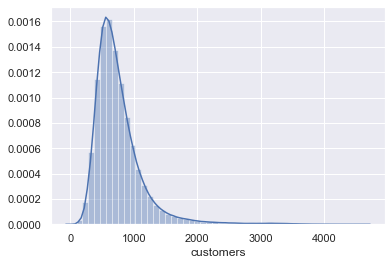

In [66]:
sns.distplot(df4['customers'])

In [67]:
df4['customers'].describe()

count    843493.000000
mean        760.133896
std         391.458882
min           8.000000
25%         519.000000
50%         675.000000
75%         892.000000
max        4645.000000
Name: customers, dtype: float64

### 4.1.2. Numerical Variables

In [68]:
# select numerical variables
num_variables = df4.select_dtypes( include=['int64', 'float64'] )

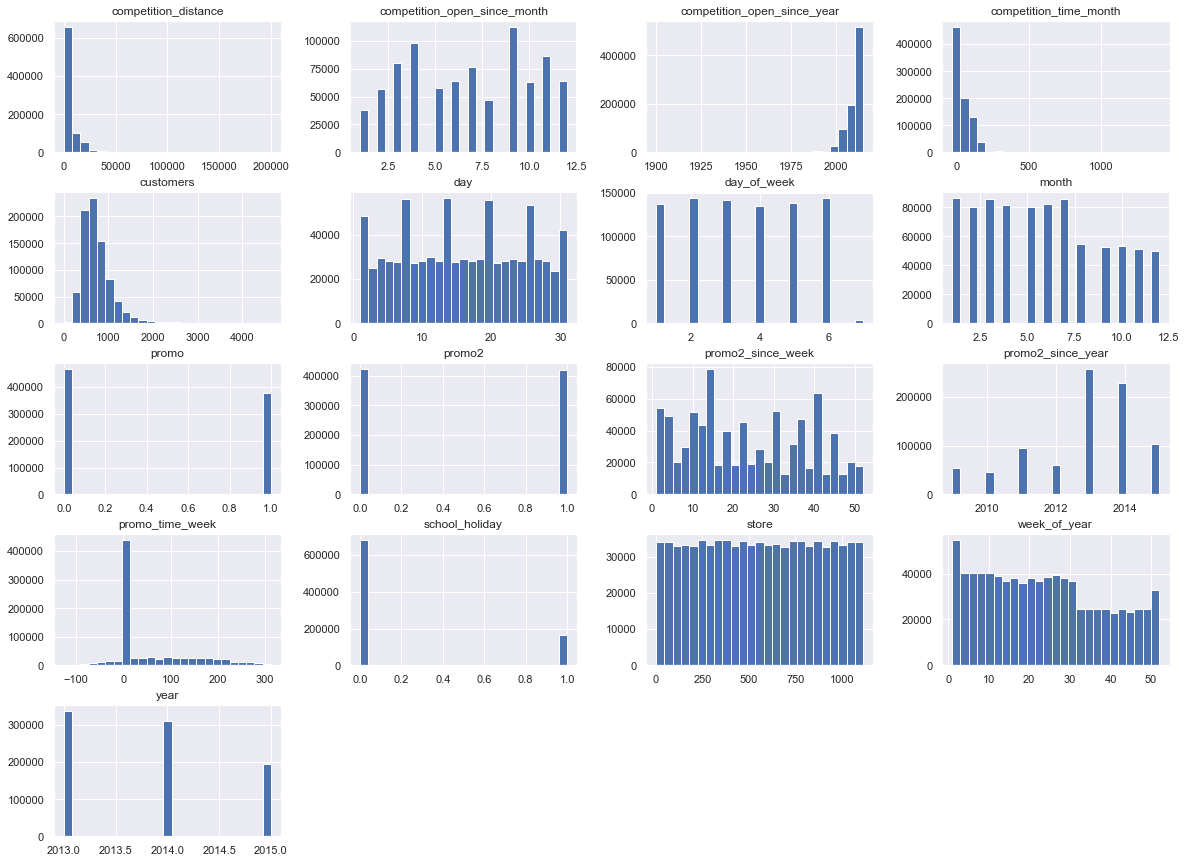

In [69]:
# plot histogram
num_variables.hist( bins=25, figsize=(20,15));

### 4.1.3. Categorical Variables

In [70]:
# select categorical variables
cat_variables = df4.select_dtypes( exclude=['int64', 'float64', 'datetime'])
cat_variables.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


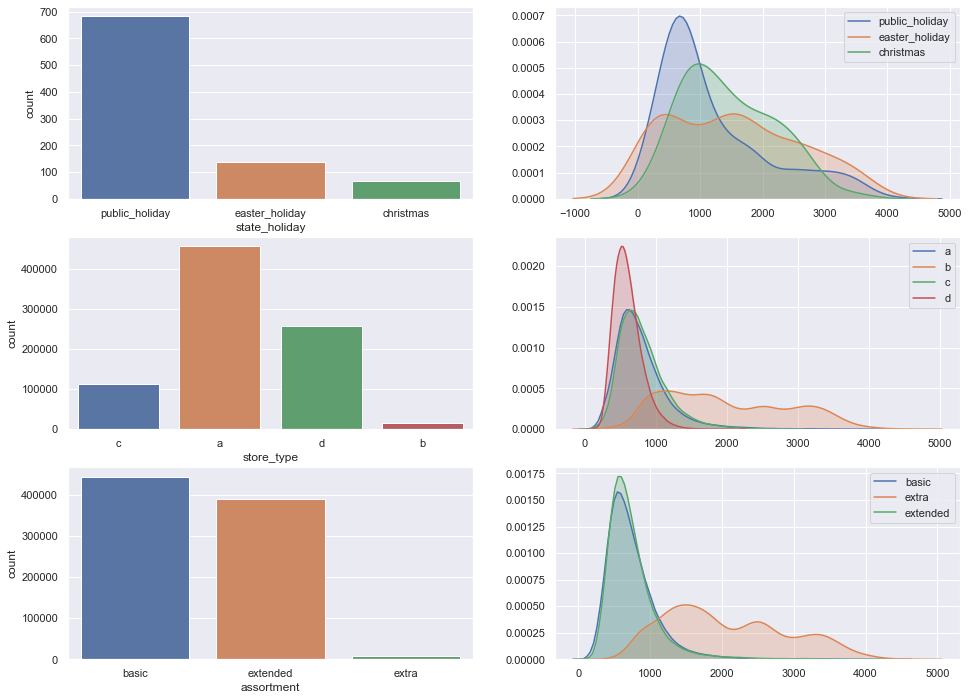

In [71]:
# setup plot figure
f, axes = plt.subplots( 3, 2, figsize=(16,12))

# state_holiday - countplot
plt.subplot( 3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] )
#state_holiday - distribution - public holiday, Easter holiday, Christmas
plt.subplot( 3, 2, 2)
sns.kdeplot( df4[ df4['state_holiday'] == 'public_holiday']['customers'], label='public_holiday', shade=True )
sns.kdeplot( df4[ df4['state_holiday'] == 'easter_holiday']['customers'], label='easter_holiday', shade=True )
sns.kdeplot( df4[ df4['state_holiday'] == 'christmas']['customers'], label='christmas', shade=True )

# store_type
plt.subplot( 3, 2, 3)
sns.countplot( df4['store_type'] )
# store_type - 4 different store models: a, b, c, d
plt.subplot( 3, 2, 4)
sns.kdeplot( df4[ df4['store_type'] == 'a']['customers'], label='a', shade=True )
sns.kdeplot( df4[ df4['store_type'] == 'b']['customers'], label='b', shade=True )
sns.kdeplot( df4[ df4['store_type'] == 'c']['customers'], label='c', shade=True )
sns.kdeplot( df4[ df4['store_type'] == 'd']['customers'], label='d', shade=True )

# assortment
plt.subplot( 3, 2, 5)
sns.countplot( df4['assortment'] )
# assortment - basic, extra, extended
plt.subplot( 3, 2, 6)
sns.kdeplot( df4[ df4['assortment'] == 'basic']['customers'], label='basic', shade=True )
sns.kdeplot( df4[ df4['assortment'] == 'extra']['customers'], label='extra', shade=True )
sns.kdeplot( df4[ df4['assortment'] == 'extended']['customers'], label='extended', shade=True )

## 4.2. Bivariate Analysis

### H1. Stores with bigger Assortment should have more customers.

**FALSE** Stores with BIGGER ASSORTMENT have LESS customers.

Assumption: extra and extended = big assortment.

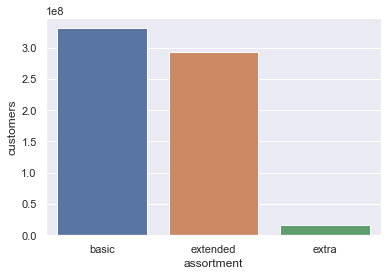

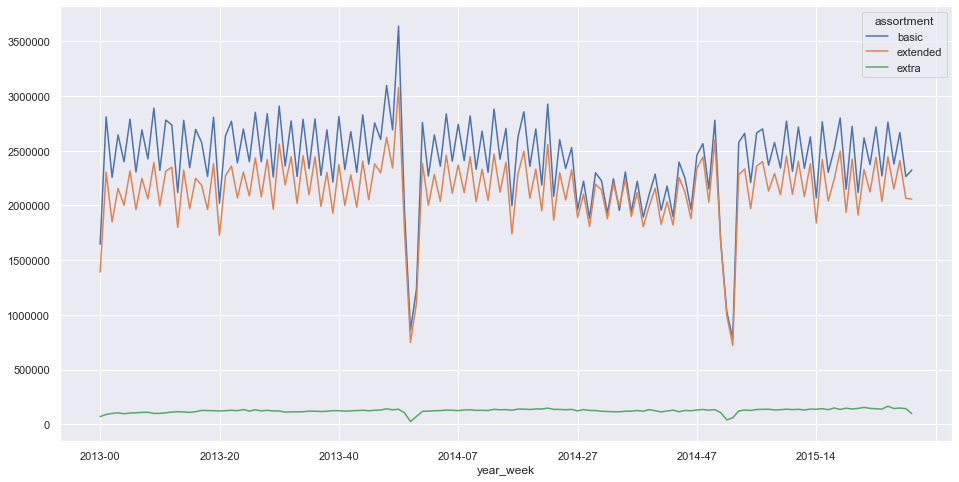

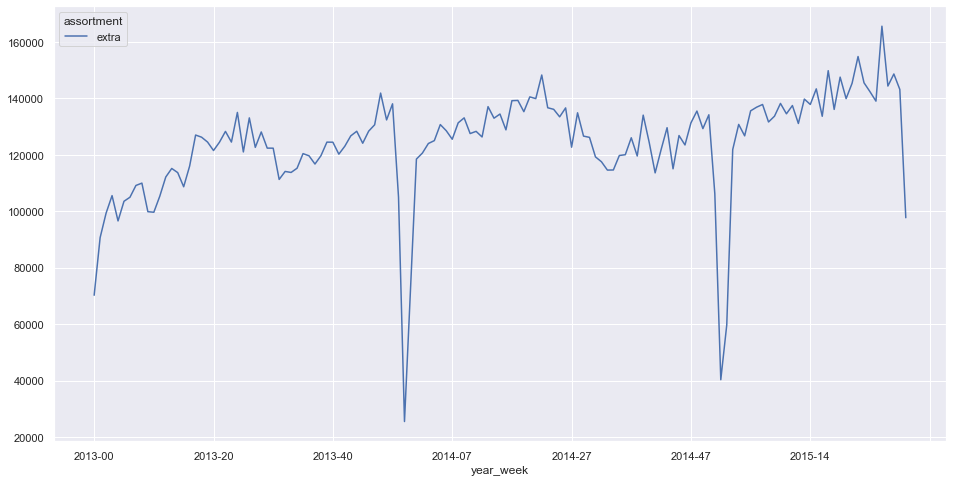

In [72]:
# plot the sum of customers by assortment
aux1 = df4[['assortment', 'customers']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x=aux1['assortment'], y=aux1['customers']);

# sum of all customers by assortment and by year_week.
aux2 = df4[['assortment', 'year_week', 'customers']].groupby(['year_week', 'assortment']).sum().reset_index()
# pivot table - index = year_week
aux3 = aux2.pivot( index='year_week', columns='assortment', values='customers')
aux3.plot(figsize=(16,8));

# plot the assortment type 'extra' in order to check its behaviour.
aux4 = aux2[aux2['assortment'] == 'extra']
aux4.pivot( index='year_week', columns='assortment', values='customers' ).plot(figsize=(16,8));

### H2.  Stores with competition closer should have less customers.

**FALSE** Stores with COMPETITION CLOSER have MORE customers

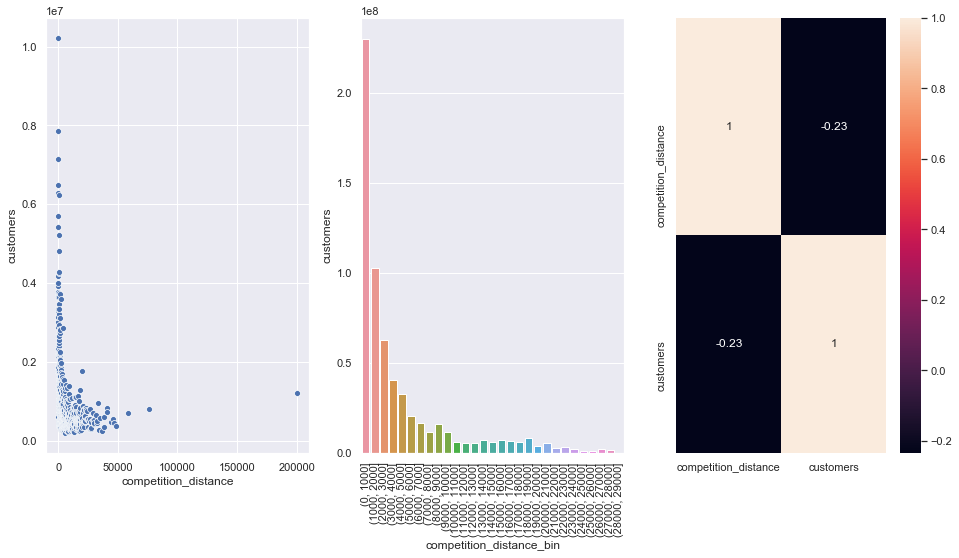

In [73]:
# set up figure size
f, ax = plt.subplots( 1, 3, figsize=(16,8))

# plot competition distance and customers
aux2_1 = df4[['competition_distance', 'customers']].groupby( 'competition_distance' ).sum().reset_index()
# grid of plots - 1st plot
plt.subplot( 1, 3, 1 )
sns.scatterplot( x='competition_distance', y='customers', data=aux2_1);

# bin - create group of distances for better barplot visualization
bins = list( np.arange( 0, 30000, 1000) )
# arrange the values to each corresponding group (bins) 
# and store it in the new column 'competition_distance_binned'.
aux2_1['competition_distance_bin'] = pd.cut( aux2_1['competition_distance'], bins=bins)
# sum of customers by competition_distance_bin
aux2_3 = aux2_1[['competition_distance_bin', 'customers']].groupby( 'competition_distance_bin' ).sum().reset_index()
# grid of plots - 2nd plot
plt.subplot( 1, 3, 2 )
# plot sum of customers by competition_distance_bin
sns.barplot( x='competition_distance_bin', y='customers', data=aux2_3 );
# axis rotation
plt.xticks( rotation=90 )

# grid of plots - 3rd plot
plt.subplot( 1, 3, 3 )
# correlation weight between customers and competition_distance
sns.heatmap( aux2_1.corr(method='pearson'), annot=True);

In [74]:
aux2_1.sample(5)

,competition_distance,customers,competition_distance_bin
240,2950.0,771078,"(2000, 3000]"
21,230.0,1763506,"(0, 1000]"
504,11640.0,341963,"(11000, 12000]"
195,2240.0,1845259,"(2000, 3000]"
275,3470.0,501318,"(3000, 4000]"


### H3.  Stores with longer time competition should have more customers.

**FALSE** Stores with LONGER TIME COMPETITION have LESS customers.

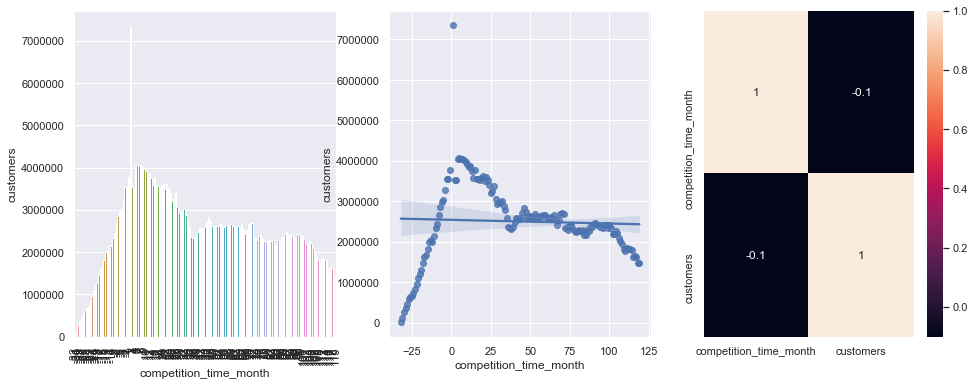

In [75]:
# competition_time_month

# set up figure size
f, ax = plt.subplots( 1, 3, figsize=(16,6))

# competition_time_month = x['date'] - x['competition_since']: negative values mean competition intention to open new stores.
aux3_1 = df4[['competition_time_month', 'customers']].groupby( 'competition_time_month' ).sum().reset_index()

# competition_time_month was created with competition_open_since_month and competition_open_since_year.
# the high customers values on competition_time_month = 0 is because competition_open_since_month and 
# competition_open_since_year NA values were filled with the date information. Hence, for a better visualization
# it is necessary to filter the values on competition_time_month = 0.
# competition time month lower than 120 and competition_time_month without zero.
aux3_2 = aux3_1[(aux3_1['competition_time_month'] < 120) & (aux3_1['competition_time_month'] != 0)]
# barplot - 1st plot
plt.subplot( 1, 3, 1)
sns.barplot( x='competition_time_month', y='customers', data=aux3_2 );
# axis rotation
plt.xticks( rotation=90 );

# scatterplot with regression line - 2nd plot
plt.subplot( 1, 3, 2)
sns.regplot( x='competition_time_month', y='customers', data=aux3_2);

# heatmap - 3rd plot
plt.subplot( 1, 3, 3)
sns.heatmap( aux3_1.corr(method='pearson'), annot=True);

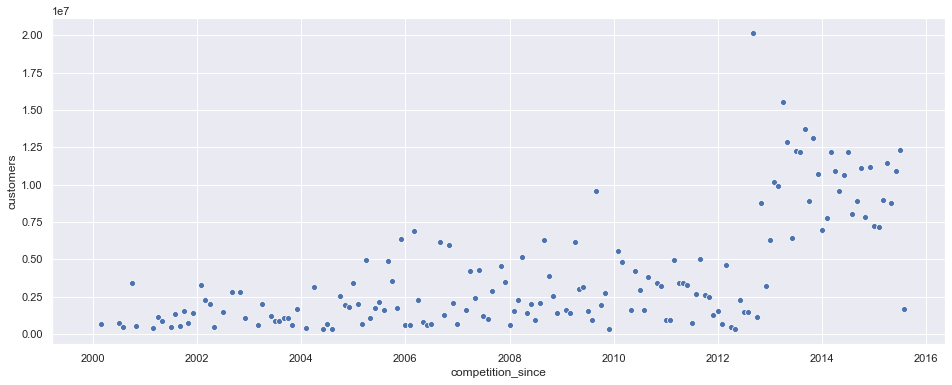

In [76]:
# competition_since

# sum of customers with respect to competition_since
aux3_3 = df4[['competition_since', 'customers']].groupby( 'competition_since' ).sum().reset_index()
aux3_4 = aux3_3[aux3_3['competition_since'] > datetime.datetime(day=1, month=1, year=2000)]

# scatterplot
plt.subplots(figsize=(16,6))
sns.scatterplot( x='competition_since', y='customers', data=aux3_4);

### H4.  Stores with longer Sale (promo) should have more customers.

**FALSE** Stores with longer sale (promo) have less customers after some period.

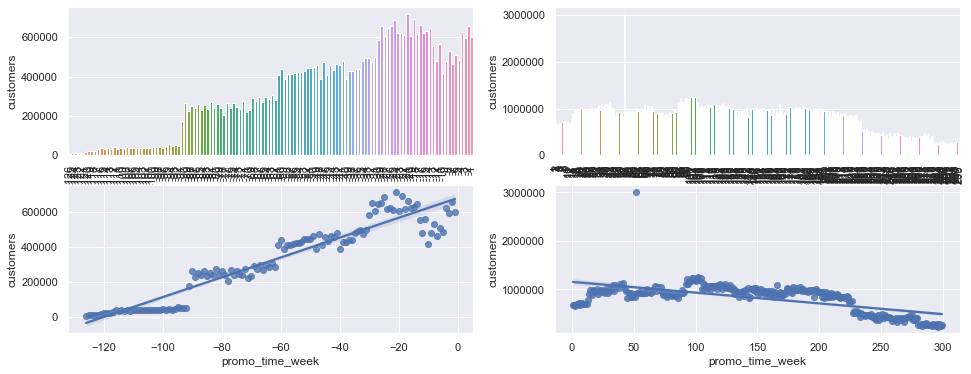

In [77]:
# promo_time_week
# df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
# df2['promo_time_week'] = df2.apply( lambda x: (( x['date'] - x['promo_since'])/7 ).days, axis=1).astype('int64')
# promo2_since_year and promo2_since_week NA values were filled with date information.
# Therefore, promo_time_week = 0 will have all the NA filled registers.
# Hence, the promo_time_week = 0 will be filtered.
aux4_1 = df4[['promo_time_week', 'customers']].groupby( 'promo_time_week' ).sum().reset_index()
aux4_2 = aux4_1[aux4_1['promo_time_week'] < 0]
# set up figure size
f, ax = plt.subplots( 2, 2, figsize=(16,6))
# barplot promo_time_week < 0 - 1st plot
plt.subplot( 2, 2, 1)
sns.barplot( x='promo_time_week', y='customers', data=aux4_2);
plt.xticks( rotation=90 );

# barplot promo_time_week > 0 - 2nd plot
aux4_3 = aux4_1[(aux4_1['promo_time_week'] > 0) & (aux4_1['promo_time_week'] < 300)]
plt.subplot( 2, 2, 2)
sns.barplot( x='promo_time_week', y='customers', data=aux4_3);
plt.xticks( rotation=90 );

# regplot promo_time_week < 0 - 3rd plot
plt.subplot(2, 2, 3)
sns.regplot(x='promo_time_week', y='customers', data=aux4_2);

# barplot promo_time_week > 0 - 4th plot
plt.subplot(2, 2, 4)
sns.regplot(x='promo_time_week', y='customers', data=aux4_3);

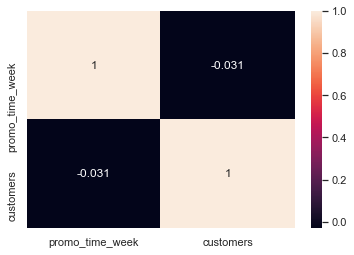

In [78]:
# heatmap
sns.heatmap(aux4_1.corr(method='pearson'), annot=True);

In [79]:
aux4_1.describe()

,promo_time_week,customers
count,440.000000,4.400000e+02
mean,93.500000,1.457199e+06
std,127.161315,1.680868e+07
min,-126.000000,7.410000e+03
25%,-16.250000,3.887800e+05
50%,93.500000,6.995610e+05
75%,203.250000,9.607795e+05
max,313.000000,3.531545e+08


### H5.  Stores with more Sale (promo) days should have more customers.

**FALSE** Stores with more sale (promo) days have LESS customers.

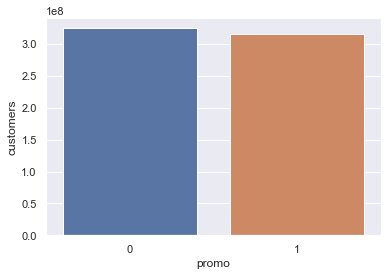

In [80]:
# promo, customers
aux5_1 = df4[['promo', 'customers']].groupby( 'promo' ).sum().reset_index()
sns.barplot(x='promo', y='customers', data=aux5_1);

In [81]:
# number of customers by promo == 0 and promo == 1
print('total of customers at stores without promo: {}'.format(aux5_1['customers'][0]))
print('total of customers at stores with promo: {}'.format(aux5_1['customers'][1]))

total of customers at stores without promo: 324736404
total of customers at stores with promo: 316431216


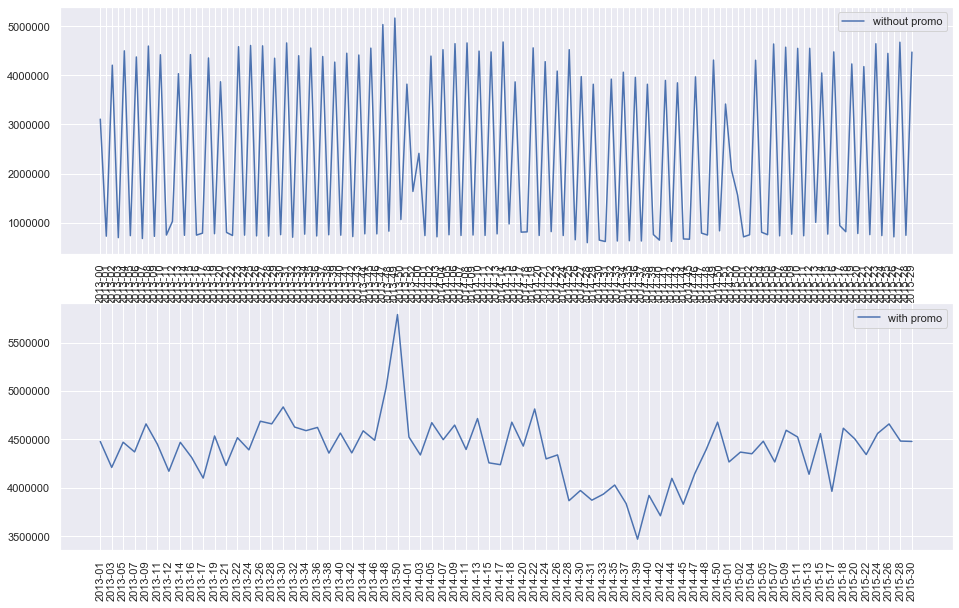

In [82]:
# time series promo, year_week and customers
aux5_2 = df4[df4['promo'] == 0][['year_week', 'customers']].groupby('year_week').sum().reset_index()
aux5_2 = aux5_2.set_index('year_week')
# set up plot
plt.subplots(2, 1, figsize=(16,10))
# lineplot promo == 0 - 1st plot
plt.subplot(2, 1, 1)
sns.lineplot(data=aux5_2['customers'], label='without promo');
plt.xticks(rotation=90);

# with promo
aux5_3 = df4[df4['promo'] == 1][['year_week', 'customers']].groupby('year_week').sum().reset_index()
aux5_3 = aux5_3.set_index('year_week')
# lineplot promo == 1 - 2nd plot
plt.subplot(2, 1, 2)
sns.lineplot(data=aux5_3['customers'], label='with promo');
plt.xticks(rotation=90);

In [83]:
aux5_3.tail()

,customers
year_week,
2015-22,4344406
2015-24,4562514
2015-26,4660463
2015-28,4483573
2015-30,4479968


### H6.  Stores with more consecutive Sale (promo) should have more customers.

**FALSE** Stores with more consecutive Sale (promo) have LESS customers.

In [84]:
# promo, promo2, customers
aux6 = df4[['promo', 'promo2', 'customers']].groupby(['promo', 'promo2']).sum().reset_index()
aux6

,promo,promo2,customers
0,0,0,180639366
1,0,1,144097038
2,1,0,173923705
3,1,1,142507511


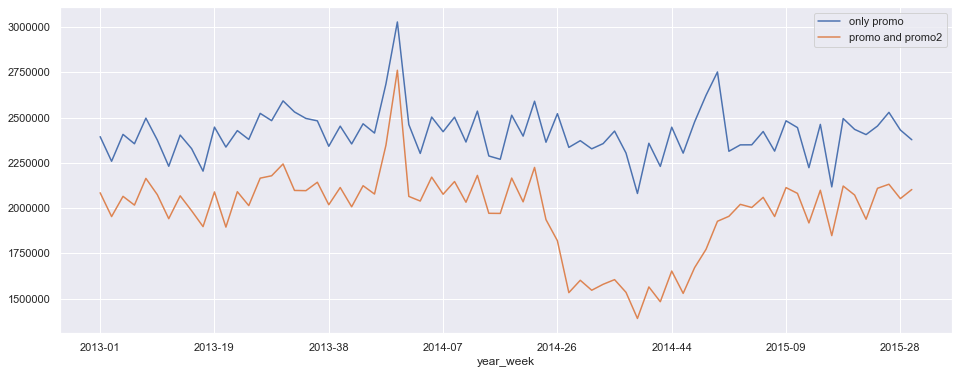

In [85]:
# stores in promo and without promo2
aux6_1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'customers']].groupby('year_week').sum().reset_index()
aux6_1 = aux6_1.set_index('year_week')
ax = aux6_1.plot(figsize=(16,6))

# stores in promo and with promo2
aux6_2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'customers']].groupby('year_week').sum().reset_index()
aux6_2 = aux6_2.set_index('year_week')
aux6_2.plot(ax=ax)

ax.legend(labels=['only promo', 'promo and promo2'])

### H7.  Stores open on Christmas time should have more customers.

**FALSE** Stores open on Christmas have LESS customers

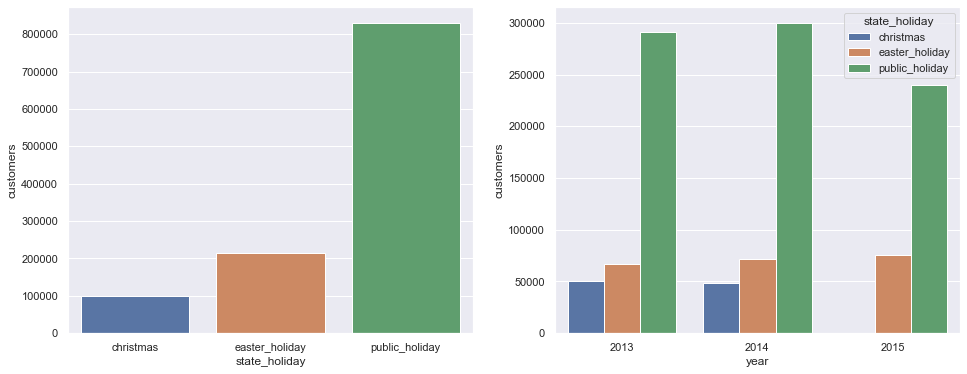

In [86]:
# set up plots
plt.subplots(1, 2, figsize=(16,6))

# state holiday without regular day
aux7_1 = df4[df4['state_holiday'] != 'regular_day'][['state_holiday', 'customers']].groupby('state_holiday').sum().reset_index()
# barplot - 1st plot
plt.subplot(1, 2, 1)
sns.barplot(x='state_holiday', y='customers', data=aux7_1);

# state holiday by year
aux7_2 = df4[df4['state_holiday'] != 'regular_day'][['state_holiday','year', 'customers']].groupby(['year', 'state_holiday']).sum().reset_index()
# barplot - 2nd plot
plt.subplot(1, 2, 2)
sns.barplot(x='year', y='customers', hue='state_holiday', data=aux7_2);

### H8.  Stores should have more customers throughout the years.

**FALSE** Stores have LESS customers throughout the years.

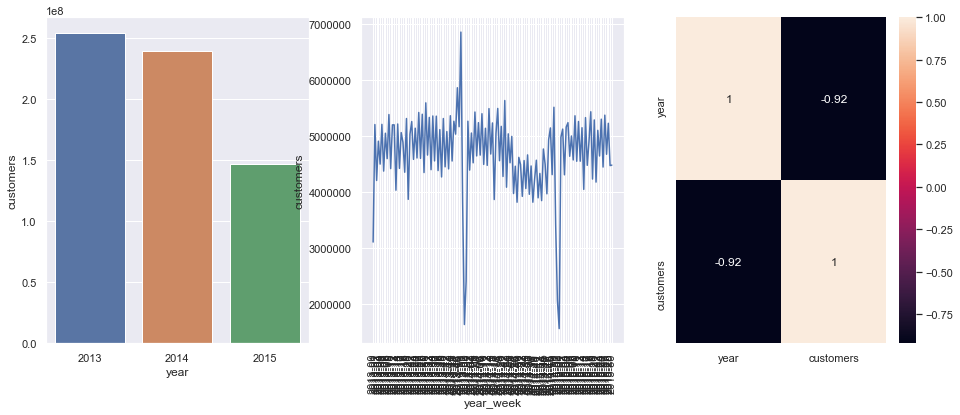

In [87]:
# set up plot
plt.subplots(1, 3, figsize=(16,6))

# year, customers
aux8_1 = df4[['year', 'customers']].groupby('year').sum().reset_index()
# barplot - 1st plot
plt.subplot(1, 3, 1)
sns.barplot(x='year', y='customers', data=aux8_1);

# year_week regplot
aux8_2 = df4[['year_week','customers']].groupby('year_week').sum().reset_index()
# lineplot - 2nd plot
plt.subplot(1, 3, 2)
sns.lineplot(x='year_week', y='customers', data=aux8_2);
plt.xticks(rotation=90);

# heatmap
plt.subplot(1, 3, 3)
sns.heatmap(aux8_1.corr(method='pearson'), annot=True);

### H9.  Stores should have more customers between April and September.

**FALSE** Stores have the same amount of customers between april and September

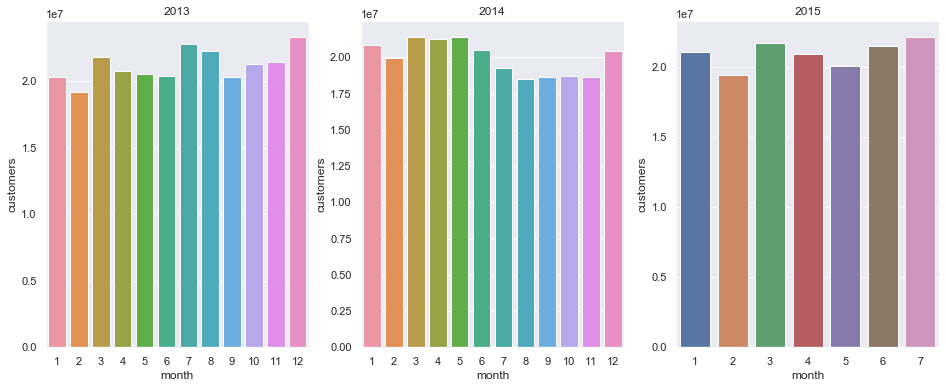

In [88]:
# month, year
# year 2013
aux9_1 = df4[df4['year'] == 2013][['month', 'customers']].groupby('month').sum().reset_index()
# plots
plt.subplots(1, 3, figsize=(16,6))
# 2013 - 1st plot
plt.subplot(1, 3, 1)
plt.title('2013')
sns.barplot(x='month', y='customers', data=aux9_1);



# year 2014
aux9_2 = df4[df4['year'] == 2014][['month', 'customers']].groupby('month').sum().reset_index()
# 2014 - 2nd plot
plt.subplot(1, 3, 2)
plt.title('2014')
sns.barplot(x='month', y='customers', data=aux9_2);

# year 2015
aux9_3 = df4[df4['year'] == 2015][['month', 'customers']].groupby('month').sum().reset_index()
# 2015 - 3rd plot
plt.subplot(1, 3, 3)
plt.title('2015')
sns.barplot(x='month', y='customers', data=aux9_3);

C:\Users\santo\Anaconda3\envs\ds-em-producao\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


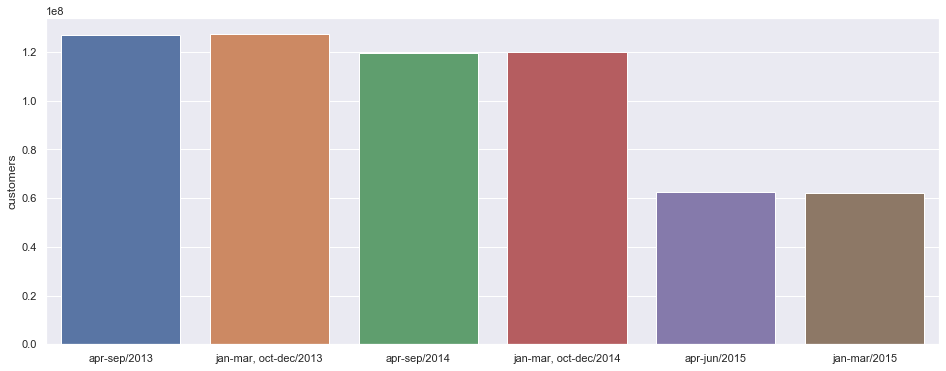

In [89]:
# sum of customers between april and september 2013
aux9_1_1 = aux9_1[(aux9_1['month'] > 3) & (aux9_1['month'] < 10)]['customers'].sum()
# sum of customers between april and september 2014
aux9_1_2 = aux9_2[(aux9_2['month'] > 3) & (aux9_2['month'] < 10)]['customers'].sum()
# sum of customers between april and june 2015
aux9_1_3 = aux9_3[(aux9_3['month'] > 3) & (aux9_2['month'] < 7)]['customers'].sum()


# sum of customers jan-mar and oct-dec 2013
aux9_1_4 = aux9_1[aux9_1['month'] < 4]['customers'].sum() + aux9_1[aux9_1['month'] > 9]['customers'].sum()
# sum of customers jan-mar and oct-dec 2014
aux9_1_5 = aux9_2[aux9_2['month'] < 4]['customers'].sum() + aux9_2[aux9_2['month'] > 9]['customers'].sum()
# sum of customers jan-mar and oct-dec 2015
aux9_1_6 = aux9_3[aux9_3['month'] < 4]['customers'].sum() + aux9_3[aux9_3['month'] > 9]['customers'].sum()

df9_1 = pd.DataFrame({'customers':[aux9_1_1, aux9_1_4, aux9_1_2, aux9_1_5, aux9_1_3, aux9_1_6]}, 
                     index=['apr-sep/2013', 'jan-mar, oct-dec/2013','apr-sep/2014','jan-mar, oct-dec/2014',
                           'apr-jun/2015', 'jan-mar/2015'])

plt.subplots(figsize=(16,6))
sns.barplot(x=df9_1.index, y='customers', data=df9_1)

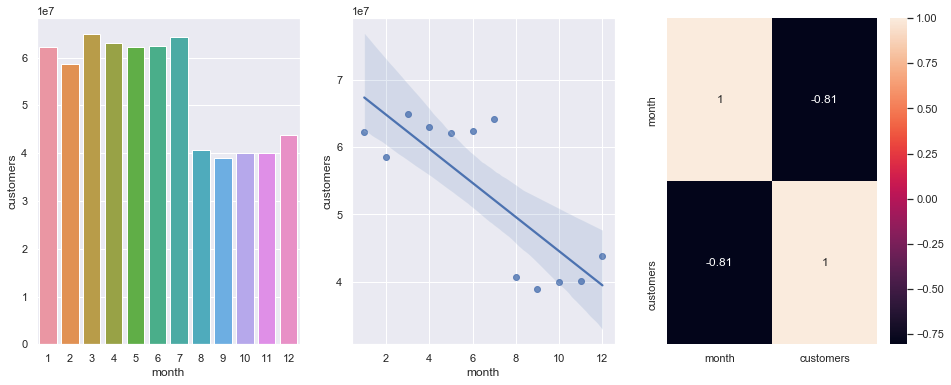

In [90]:
# sum customers and all months
# set up figure size
plt.subplots(1, 3, figsize=(16,6))

aux9_4 = df4[['month', 'customers']].groupby('month').sum().reset_index()
# sum of customers by month - 1st plot
plt.subplot(1, 3, 1)
sns.barplot(x='month', y='customers', data=aux9_4);

# regplot - 2nd plot
plt.subplot(1, 3, 2)
sns.regplot(x='month', y='customers', data=aux9_4);

# heatmap - 3rd plot
plt.subplot(1, 3, 3)
sns.heatmap( aux9_4.corr(method='pearson'), annot=True);

### H10.  Stores should have more customers after the 10th months day.

**TRUE** Stores have more customers after the 10th Months day.

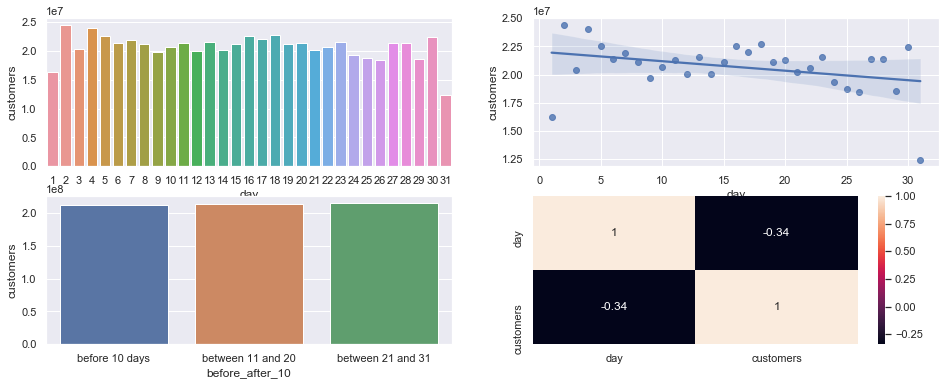

In [91]:
# day, customers
aux10 = df4[['day', 'customers']].groupby('day').sum().reset_index()
# set up plot
plt.subplots(2,2,figsize=(16,6))
# barplot - 1st plot
plt.subplot(2, 2, 1)
sns.barplot(x='day', y='customers', data=aux10);

# regplot - 2nd plot
plt.subplot(2, 2, 2)
sns.regplot(x='day', y='customers', data=aux10);


# before and after 10 days
aux10['before_after_10'] = aux10['day'].apply( lambda x: 'before 10 days' if x <= 10 else 'between 11 and 20' if (x > 10 and x <= 20) else 'between 21 and 31')
aux10_1 = aux10.groupby('before_after_10').sum().reset_index()
# barplot - 3rd plot
plt.subplot(2, 2, 3)
sns.barplot(x='before_after_10', y='customers', data=aux10_1);

# heatmap - 4th plot
plt.subplot(2, 2, 4)
aux10_2 = df4[['day', 'customers']].groupby('day').sum().reset_index()
sns.heatmap(aux10_2.corr(method='pearson'), annot=True);

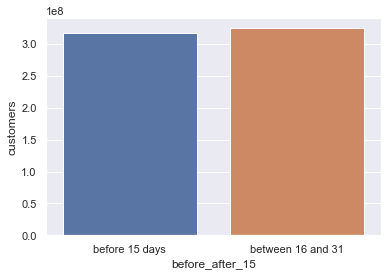

In [92]:
# before and after 15 days
aux10_3 = df4[['day', 'customers']].groupby('day').sum().reset_index()
aux10_3['before_after_15'] = aux10_3['day'].apply( lambda x: 'before 15 days' if x <= 15 else 'between 16 and 31' )
aux10_4 = aux10_3.groupby('before_after_15').sum().reset_index()
# barplot - 3rd plot
#plt.subplot(2, 2, 3)
sns.barplot(x='before_after_15', y='customers', data=aux10_4);

In [93]:
aux10_4

,before_after_15,day,customers
0,before 15 days,120,316540149
1,between 16 and 31,376,324627471


In [94]:
aux10_1

,before_after_10,day,customers
0,before 10 days,55,212492880
1,between 11 and 20,155,213684366
2,between 21 and 31,286,214990374


### H11.  Stores should have more customers on weekend.

**FALSE** Stores have less customers on wekeend.

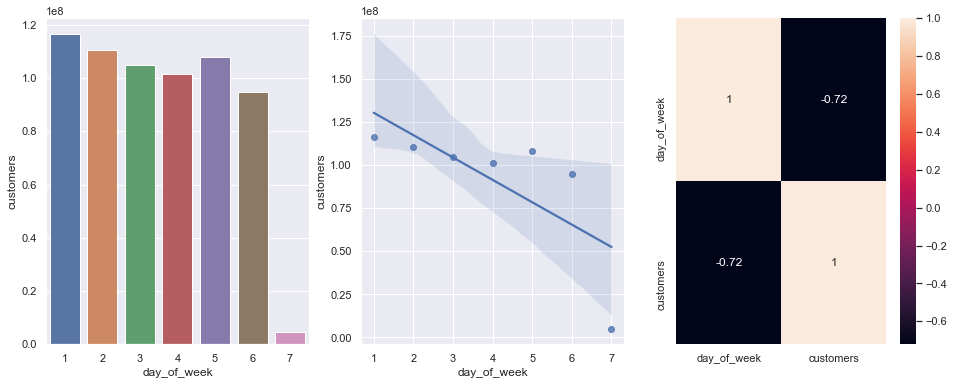

In [100]:
# day of week
# ISO week day: Monday is 1 and Sunday is 7.
aux11 = df4[['day_of_week', 'customers']].groupby('day_of_week').sum().reset_index()
# set up plot
plt.subplots(1, 3, figsize=(16,6))
# barplot - 1st plot
plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='customers', data=aux11);

# regplot - 2nd plot
plt.subplot(1, 3, 2);
sns.regplot(x='day_of_week', y='customers', data=aux11);

# heatmap - 3rd plot
plt.subplot(1, 3, 3)
sns.heatmap( aux11.corr(method='pearson'), annot=True);

### H12.  Stores should have less customers while school vacation.

**TRUE** Stores have less customers while school vacation.

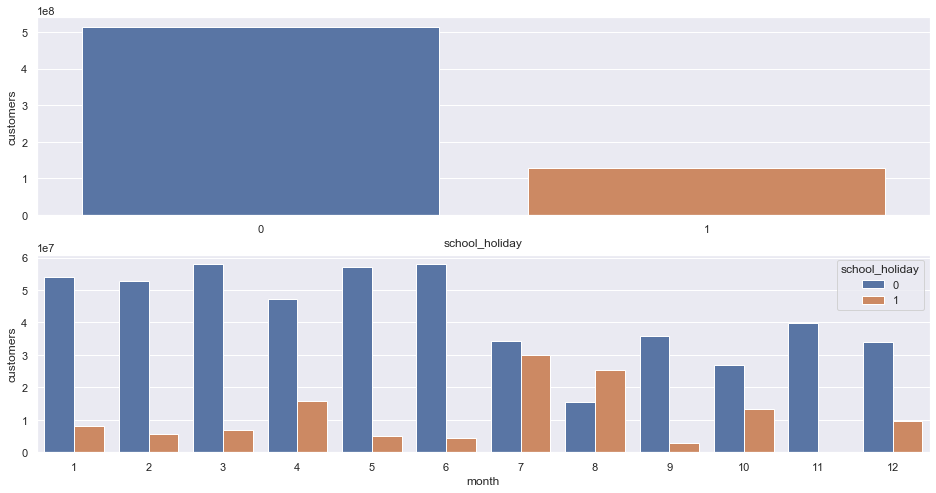

In [105]:
# state_holiday, school_holiday
aux12 = df4[['school_holiday', 'customers']].groupby('school_holiday').sum().reset_index()
# set up plot
plt.subplots(2, 1, figsize=(16,8))
# barplot school_holiday x customers - 1st plot
plt.subplot(2, 1, 1)
sns.barplot(x='school_holiday', y='customers', data=aux12);

# month, school_holiday, customers
aux12_1 = df4[['month', 'school_holiday', 'customers']].groupby(['month', 'school_holiday']).sum().reset_index()
# barplot month, school_holiday, customers - 2nd plot
plt.subplot(2, 1, 2)
sns.barplot( x='month', y='customers', hue='school_holiday', data=aux12_1);

### 4.2.1. Hypothesis Summary

In [107]:
# Hypothesis Summary dataframe
summary = pd.DataFrame({'Hypothesis':['Stores with bigger Assortment should have more customers.',
                                      'Stores with competition closer should have less customers.',
                                      'Stores with longer time competition should have more customers.',
                                      'Stores with longer Sale (promo) should have more customers.',
                                      'Stores with more Sale (promo) days should have more customers.',
                                      'Stores with more consecutive Sale (promo) should have more customers.',
                                      'Stores open on Christmas time should have more customers.',
                                      'Stores should have more customers throughout the years.',
                                      'Stores should have more customers between April and September.',
                                      'Stores should have more customers after the 10th months day.',
                                      'Stores should have more customers on weekend.',
                                      'Stores should have less customers while school vacation.'],
                        'True / False':['False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False',
                                        'True', 'False', 'True'], 
                        'Relevance':['Low', 'Medium', 'Medium', 'Low', 'Low', 'Low', 'Medium', 'High', 'High', 'High',
                                     'High', 'Low']}, 
                        index=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
summary

,Hypothesis,True / False,Relevance
1,Stores with bigger Assortment should have more customers.,False,Low
2,Stores with competition closer should have less customers.,False,Medium
3,Stores with longer time competition should have more customers.,False,Medium
4,Stores with longer Sale (promo) should have more customers.,False,Low
5,Stores with more Sale (promo) days should have more customers.,False,Low
6,Stores with more consecutive Sale (promo) should have more customers.,False,Low
7,Stores open on Christmas time should have more customers.,False,Medium
8,Stores should have more customers throughout the years.,False,High
9,Stores should have more customers between April and September.,False,High
10,Stores should have more customers after the 10th months day.,True,High


## 4.3. Multivariate Analysis

### 4.3.1. Numerical Attributes

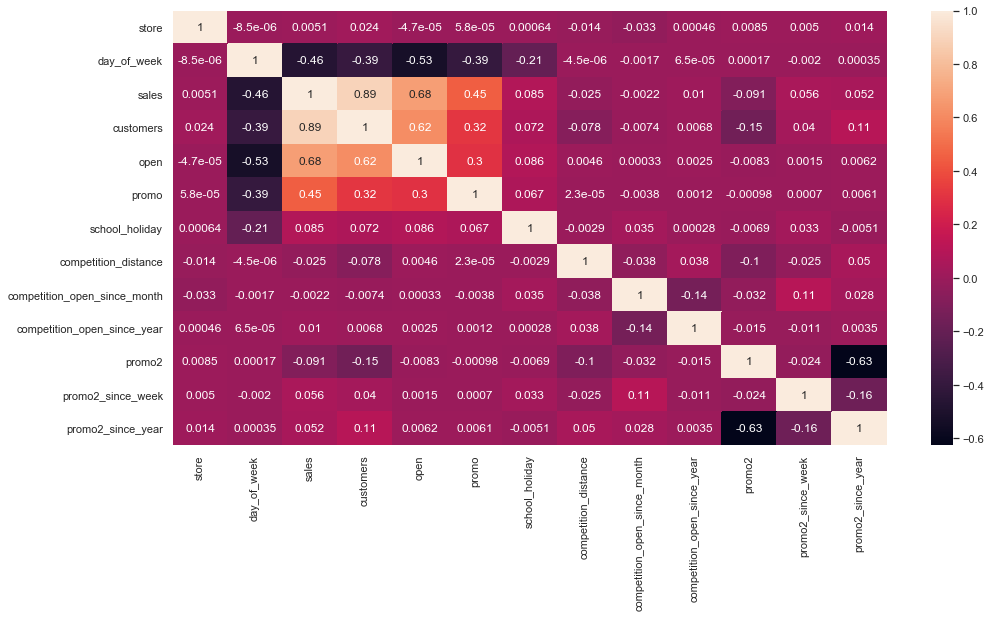

In [111]:
# correlation pearson method
# num_attributes from item 1.7.1 (df1)
correlation = num_attributes.corr(method='pearson')

# set up plot
plt.subplots(figsize=(16,8))
# heatmap
sns.heatmap(correlation, annot=True);

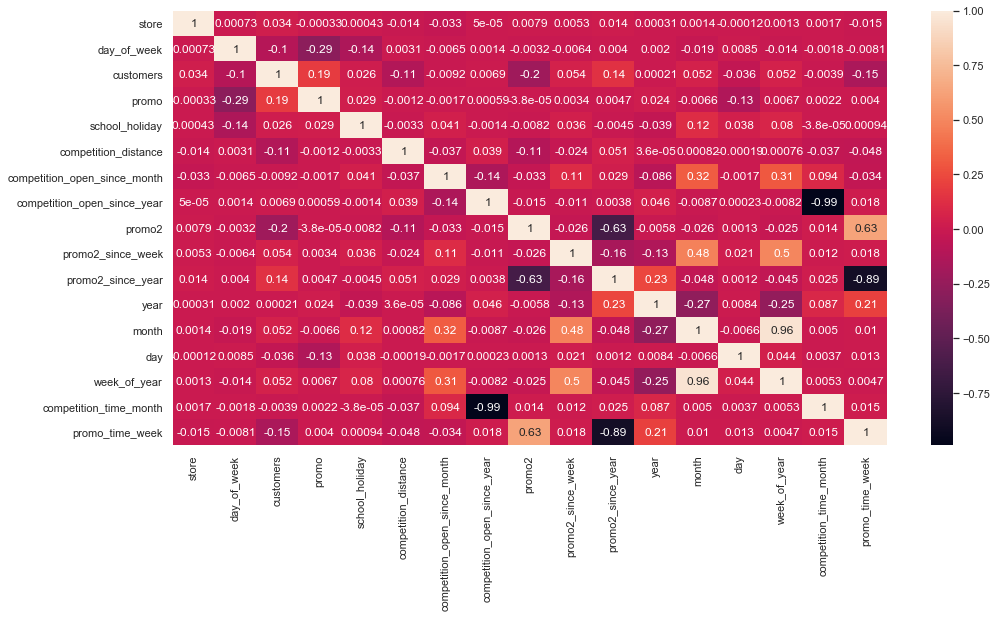

In [112]:
# correlation pearson method
# num_attributes_df4 from df4 (with feature engineering and variables filtering)
num_attributes_df4 = df4.select_dtypes(include=['float64', 'int64'])
correlation_df4 = num_attributes_df4.corr(method='pearson')

# set up plot
plt.subplots(figsize=(16,8))
# heatmap
sns.heatmap(correlation_df4, annot=True);

### 4.3.2. Categorical Attributes

In [114]:
# select categorical variables
a = df4.select_dtypes(include='object')
a.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


In [128]:
# cramer_v applied to each categorical combination
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# summary dataframe
d = pd.DataFrame({'state_holiday':[a1, a2, a3],
                  'store_type':[a4, a5, a6],
                  'assortment':[a7, a8, a9]},
                  index=['state_holiday', 'store_type', 'assortment'])

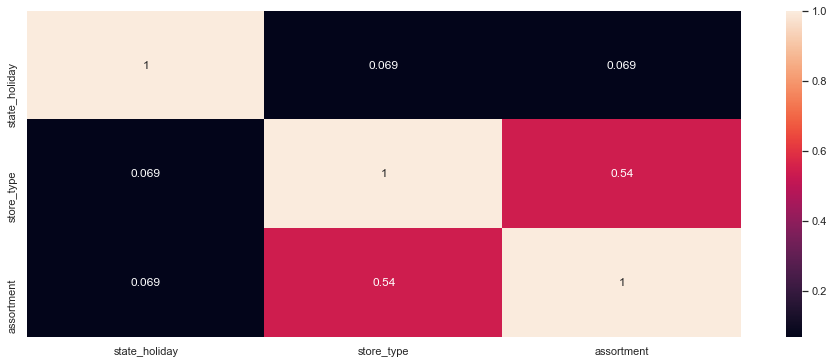

In [131]:
# categorical variables heatmap
plt.subplots(figsize=(16,6))
sns.heatmap(data=d,annot=True);

# 5.0. Data Preparation

In [29]:
# copy df4
df5 = df4.copy()

In [29]:
df5.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
customers,555,625,821,1498,559
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a
assortment,basic,basic,basic,extended,basic
competition_distance,1270,570,14130,620,29910


## 5.1. Rescaling

In [37]:
df5[['competition_distance', 'competition_time_month', 'competition_open_since_year']].describe()

,competition_distance,competition_time_month,competition_open_since_year
count,843493.000000,843493.000000,843493.000000
mean,5966.188149,41.684249,2010.330646
std,12596.971783,66.832258,5.504085
min,20.000000,-32.000000,1900.000000
25%,710.000000,0.000000,2008.000000
50%,2330.000000,16.000000,2012.000000
75%,6910.000000,74.000000,2014.000000
max,200000.000000,1407.000000,2015.000000


In [39]:
# year variables
df5[['year', 'competition_open_since_year', 'promo2_since_year']].describe()

,year,competition_open_since_year,promo2_since_year
count,843493.000000,843493.000000,843493.000000
mean,2013.832048,2010.330646,2012.797363
std,0.777286,5.504085,1.660375
min,2013.000000,1900.000000,2009.000000
25%,2013.000000,2008.000000,2012.000000
50%,2014.000000,2012.000000,2013.000000
75%,2014.000000,2014.000000,2014.000000
max,2015.000000,2015.000000,2015.000000


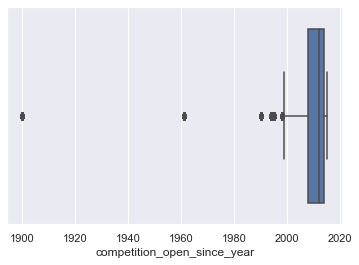

In [38]:
sns.boxplot(df5['competition_open_since_year'])

In [30]:
# numerical variables: competition_distance, competition_time_month, promo_time_week, year
# competition_open_since_year, promo2_since_year

# 1. Robust Scaler - for variables with high outliers influence
rs = RobustScaler()
# competition_distance, competition_time_month and competition_open_since_year
# competition_distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
# competition_time_month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
# competition_open_since_year
df5['competition_open_since_year'] = rs.fit_transform( df5[['competition_open_since_year']].values )

# 2. Min-Max Scaler - for variables with low outliers influence
mms = MinMaxScaler()
# competition_time_month, promo_time_week, year, promo2_since_year
# competition_time_month
df5['competition_time_month'] = mms.fit_transform( df5[['competition_time_month']].values )
# promo_time_week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
# year
df5['year'] = mms.fit_transform( df5[['year']].values )
# promo2_since_year
df5['promo2_since_year'] = mms.fit_transform( df5[['promo2_since_year']].values )

## 5.2. Transformation

### 5.2.1. Encoding

In [31]:
# categorical variables - state_holiday, store_type, assortment

# state_holiday - one hot encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - label encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )

# assortment - Ordinal Encoding
assortment_dict = {'basic':1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

In [32]:
df5.head()

,store,day_of_week,date,customers,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,555,1,1,2,1,-0.170968,9,...,31,2015-30,2008-09-01,0.080612,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,625,1,1,0,1,-0.283871,11,...,31,2015-30,2007-11-01,0.087561,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,821,1,1,0,1,1.903226,12,...,31,2015-30,2006-12-01,0.095205,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,1498,1,1,2,3,-0.275806,9,...,31,2015-30,2009-09-01,0.071577,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,559,1,1,0,1,4.448387,4,...,31,2015-30,2015-04-01,0.025017,2015-07-27,0.287016,0,0,0,1


### 5.2.2. Nature Transformation

In [32]:
# time variables - day_of_week, day, month, week_of_year, competition_open_since_month, promo2_since_week.

# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * (2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * (2. * np.pi/7) ) )

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * (2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * (2. * np.pi/30 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * (2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * (2. * np.pi/12 ) ) )

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * (2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * (2. * np.pi/52 ) ) )

# competition_open_since_month
df5['competition_open_since_month_sin'] = df5['competition_open_since_month'].apply( lambda x: np.sin( x * (2. * np.pi/12 ) ) )
df5['competition_open_since_month_cos'] = df5['competition_open_since_month'].apply( lambda x: np.cos( x * (2. * np.pi/12 ) ) )

# promo2_since_week
df5['promo2_since_week_sin'] = df5['promo2_since_week'].apply( lambda x: np.sin( x * (2. * np.pi/52 ) ) )
df5['promo2_since_week_cos'] = df5['promo2_since_week'].apply( lambda x: np.cos( x * (2. * np.pi/52 ) ) )

### 5.2.3. Response (Target) Transformation

In [33]:
# customers - Log Transformation
df5['customers'] = np.log1p( df5['customers'] )

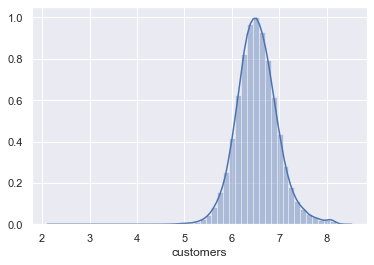

In [34]:
sns.distplot(df5['customers'])

In [38]:
df5['customers'].describe()

count    843493.000000
mean          6.533941
std           0.436860
min           2.197225
25%           6.253829
50%           6.516193
75%           6.794587
max           8.443762
Name: customers, dtype: float64

# 6.0. Feature Selection

In [35]:
df6 = df5.copy()

## 6.1. Split Dataframe into Training and Test Datasets

In [82]:
df6.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
customers,6.32077,6.43935,6.71174,7.31255,6.32794
promo,1,1,1,1,1
school_holiday,1,1,1,1,1
store_type,2,0,0,2,0
assortment,1,1,1,3,1
competition_distance,-0.170968,-0.283871,1.90323,-0.275806,4.44839
competition_open_since_month,9,11,12,9,4


In [36]:
# Remove columns that already have a derivative one

# Remove day_of_week due to day_of_week_sin, day_of_week_cos
# Remove competition_open_since_month due to competition_open_since_month_sin, competition_open_since_month_cos
# Remove promo2_since_week due to promo2_since_week_sin, promo2_since_week_cos
# Remove month due to month_sin, month_cos
# Remove day due to day_sin, day_cos
# Remove week_of_year due to week_of_year_sin, week_of_year_cos
# Remove year_week due to week_of_year_sin, week_of_year_cos
# Remove competition_since due to competition_open_since_year, competition_time_month, competition_open_since_month_sin, competition_open_since_month_cos
# Remove promo_since due to promo_time_week, promo2_since_week_sin, promo2_since_week_cos
cols_drop = ['day_of_week', 'competition_open_since_month', 'promo2_since_week', 'month', 'day', 'week_of_year', 
             'year_week', 'competition_since', 'promo_since']

df6 = df6.drop( cols_drop, axis=1 )

In [34]:
# Timeseries - check the last-6-week-day
aux1 = df6[['store', 'date']].groupby('store').max().reset_index()
aux1['date'].describe()

count                    1115
unique                      4
top       2015-07-31 00:00:00
freq                     1110
first     2015-07-10 00:00:00
last      2015-07-31 00:00:00
Name: date, dtype: object

In [35]:
# check stores that do not have observations on 2015-07-31
aux2 = aux1[aux1['date'] < '2015-07-31']
aux2

,store,date
261,262,2015-07-30
291,292,2015-07-10
755,756,2015-07-30
875,876,2015-07-15
1113,1114,2015-07-30


In [36]:
# last 6 weeks of stores that do not have observations on 2015-07-31
aux2['last_6_weeks'] = aux2['date'].apply( lambda x: x-datetime.timedelta(days=6*7))
aux2

C:\Users\santo\Anaconda3\envs\ds-em-producao\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,store,date,last_6_weeks
261,262,2015-07-30,2015-06-18
291,292,2015-07-10,2015-05-29
755,756,2015-07-30,2015-06-18
875,876,2015-07-15,2015-06-03
1113,1114,2015-07-30,2015-06-18


In [37]:
# Select the last 6 weeks for the Test Dataset
# Check the day that represents the beginning of the last 6 weeks
df6[['store', 'date']].groupby( 'store' ).max().reset_index()['date'][0] - datetime.timedelta( days=6*7 )

Timestamp('2015-06-19 00:00:00')

In [37]:
# train dataset - entries before the last 6 weeks
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['customers']

# test dataset - entries from the last 6 weeks
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['customers']

# print Min and Max date values
print( 'Min. train date: {}'.format(X_train['date'].min()))
print( 'Max. train date: {}'.format(X_train['date'].max()))

print( '\nMin. test date: {}'.format(X_test['date'].min()))
print( 'Max. test date: {}'.format(X_test['date'].max()))

Min. train date: 2013-01-01 00:00:00
Max. train date: 2015-06-18 00:00:00

Min. test date: 2015-06-19 00:00:00
Max. test date: 2015-07-31 00:00:00


## 6.2. Boruta as a Feature Selector

In [90]:
# Boruta disabled in module 07 in order to not run again, since it takes at least 1h 45min.

# Boruta does not accept pandas dataframe format, therefore the dataset must be converted to numpy values
# train and test dataset for boruta
#x_train_n = X_train.drop(['date', 'customers'], axis=1).values

# ravel() place the values into a vector
#y_train_n = y_train.values.ravel()

# set RandomForestRegressor
#rf = RandomForestRegressor( n_jobs = -1 )

# Boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( x_train_n, y_train_n )

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	20
Tentative: 	0
Rejected: 	8


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	20
Tentative: 	0
Rejected: 	8


### 6.2.1. Best Features from Boruta

In [92]:
# Boruta disabled in module 07 in order to not run again, since it takes at least 1h 45min.

# columns selected by Boruta
#cols_selected = boruta.support_.tolist()

# best features by boruta
#x_train_fs = X_train.drop( ['date', 'customers'], axis=1 )
#cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

# features not selected by boruta
#cols_not_selected_boruta = list( np.setdiff1d ( x_train_fs.columns, cols_selected_boruta ))

#cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_year',
 'promo2',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'day_sin',
 'day_cos',
 'month_cos',
 'week_of_year_cos',
 'competition_open_since_month_sin',
 'competition_open_since_month_cos',
 'promo2_since_week_sin',
 'promo2_since_week_cos']

In [93]:
#cols_not_selected_boruta

['month_sin',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'week_of_year_sin',
 'year']

In [39]:
# Features selected by Boruta
cols_selected_boruta = [
 'store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_year',
 'promo2',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'day_sin',
 'day_cos',
 'month_cos',
 'week_of_year_cos',
 'competition_open_since_month_sin',
 'competition_open_since_month_cos',
 'promo2_since_week_sin',
 'promo2_since_week_cos']

In [40]:
# Features not selected by Boruta
cols_not_selected_boruta = [
 'month_sin',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'week_of_year_sin',
 'year']

## 6.3. Manual Feature Selection

In [38]:
# selected features by Boruta
# Added month_sin and week_of_year_sin because month_cos and week_of_year_cos were selected by Boruta.
cols_selected_boruta = [
 'store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_year',
 'promo2',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'day_sin',
 'day_cos',
 'month_cos',
 'month_sin',
 'week_of_year_cos',
 'week_of_year_sin',
 'competition_open_since_month_sin',
 'competition_open_since_month_cos',
 'promo2_since_week_sin',
 'promo2_since_week_cos']

# columns to add: date and customers
feat_to_add = ['date', 'customers']

# Selected Boruta columns with date and customers. It will be applied on the cross-validation step
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7.0. Machine Learning Modelling

In [39]:
# Insert selected columns by Boruta on x_train and x_test
# date and customers not included! They will be included later.
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time series data preparation with date and customers: x_training for cross-validation step
x_training = X_train[ cols_selected_boruta_full ]

## 7.1. Average Model

In [51]:
# aux1 variable for calculation
aux1 = x_test.copy()
aux1['customers'] = y_test.copy()

# Customers mean values by stores - prediction
aux2 = aux1[['store', 'customers']].groupby('store').mean().reset_index().rename( columns={'customers' : 'predictions'})
aux1 = pd.merge( aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1(y_test), np.expm1(yhat_baseline) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,96.631712,0.49343,134.512331


## 7.2. Linear Regression Model

In [41]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1(y_test), np.expm1(yhat_lr) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,217.376642,0.314128,352.137834


The Linear Regression RMSE value is higher than the average model one, that is:
- The average model is better than the linear regression model;
- The data has a complex behaviour (non-linear).

### 7.2.1. Linear Regression Model - Cross-Validation

In [43]:
# linear regression cross-validation
lr_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )
lr_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,235.24+/-22.86,0.31+/-0.02,373.49+/-34.7


## 7.3. Linear Regression Regularized Model - Lasso

In [44]:
# Lasso model
# alpha is a multiplicative factor of each weights so that they stay in the same range.
lr_lasso = Lasso(alpha=0.01).fit(x_train, y_train)

# prediction
yhat_lr_lasso = lr_lasso.predict(x_test)

# performance
lr_lasso_result = ml_error( 'Lasso', np.expm1(y_test), np.expm1(yhat_lr_lasso) )
lr_lasso_result

,Model Name,MAE,MAPE,RMSE
0,Lasso,218.104804,0.313261,356.271622


Linear Regression regularized model (Lasso) RMSE value was higher than standard linear regression. Conclusion: the phenomenon that we measure it is not linear. It is also no simple, therefore a complex model.

### 7.3.1. Lasso - Cross-Validation

In [45]:
# lasso cross-validation
lasso_cv = cross_validation( x_training, 5, 'Lasso', lr_lasso, verbose=False )
lasso_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,236.25+/-24.46,0.31+/-0.01,378.76+/-36.39


## 7.4. Random Forest Regressor Model

In [40]:
# Random Forest Regressor Model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,56.145221,0.080647,82.742767


### 7.4.1. Random Forest Regressor - Cross-Validation

In [47]:
# Random Forest Cross-Validation
rf_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
rf_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,70.1+/-17.43,0.09+/-0.02,109.69+/-29.46


## 7.5. XGBoost Regressor Model

In [48]:
# model
# eta: Step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get 
# the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative.

# subsample: Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of 
# the training data prior to growing trees. and this will prevent overfitting. Subsampling will occur once in every boosting 
# iteration.
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100,
                              eta=0.01,
                              max_depth=10, # max_depth: max. tree depth
                              subsample=0.7,
                              colsample_bytree=0.9).fit(x_train, y_train) # xgboost is composed by many trees, sample for each tree.

# prediction
yhat_xgb = model_xgb.predict(x_test)

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,73.260304,0.105276,106.313028


### 7.5.1. XGBoost Regressor - Cross-Validation

In [49]:
# XGBoost cross-validation
xgb_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
xgb_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,91.84+/-17.17,0.12+/-0.02,135.16+/-25.23


## 7.6. Compare Model's Performance

### 7.6.1. Single Performance

In [62]:
models_result = pd.concat([baseline_result, lr_result, lr_lasso_result, rf_result, xgb_result])
models_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,56.145221,0.080647,82.742767
0,XGBoost Regressor,73.260304,0.105276,106.313028
0,Average Model,96.631712,0.493430,134.512331
0,Linear Regression,217.376642,0.314128,352.137834
0,Lasso,218.104804,0.313261,356.271622


### 7.6.2. Real Performance - Cross-Validation

In [50]:
# cross validation results dataframe
models_result_cv = pd.concat([lr_cv, lasso_cv, rf_cv, xgb_cv])
models_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,235.24+/-22.86,0.31+/-0.02,373.49+/-34.7
0,Lasso,236.25+/-24.46,0.31+/-0.01,378.76+/-36.39
0,Random Forest Regressor,70.1+/-17.43,0.09+/-0.02,109.69+/-29.46
0,XGBoost Regressor,91.84+/-17.17,0.12+/-0.02,135.16+/-25.23


# 8.0. Hyperparameter Fine Tuning

In [43]:
# XGBRegressor disabled in Step 10 due to long-time execution (aprox. 1 hour)

# Dict with values from the random search result.
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3
        }

In [44]:
# XGBRegressor disabled in Step 10 due to long-time execution (aprox. 1 hour)

# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'],
                                    eta=param_tuned['eta'],
                                    max_depth=param_tuned['max_depth'],
                                    subsample=param_tuned['subsample'],
                                    colsample_bytree=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,60.938546,0.085781,87.238471


## 8.1. XGBoost Regressor (tuned) - Cross-Validation

In [45]:
# XGBoost tuned cross-validation
xgb_cv = cross_validation( x_training, 5, 'XGBoost Regressor (tuned)', model_xgb_tuned, verbose=True )
xgb_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor (tuned),82.74+/-15.59,0.11+/-0.02,123.26+/-23.54


# 9.0. Error Translation and Interpretation

In [41]:
# select full test data
df9 = X_test[ cols_selected_boruta_full ]

# rescale customers target and predictions
df9['customers'] = np.expm1(df9['customers'])
df9['predictions'] = np.expm1(yhat_rf)

C:\Users\santo\Anaconda3\envs\ds-em-producao\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\santo\Anaconda3\envs\ds-em-producao\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## 9.1. Business Performance

In [51]:
# sum of customers, sum of predictions, mae, mape, worst and best scenarios
df91 = df9[['customers', 'predictions', 'store']].groupby('store').sum().reset_index()

# MAE
aux91 = df9[['customers', 'predictions', 'store']].groupby('store').apply( lambda x: mean_absolute_error( x['customers'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'} )
# MAPE
aux92 = df9[['customers', 'predictions', 'store']].groupby('store').apply( lambda x: mean_absolute_percentage_error( x['customers'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'} )

# merge
aux93 = pd.merge( aux91, aux92, on='store', how='inner')
aux94 = pd.merge( df91, aux93, on='store', how='inner')

# scenarios
aux94['worst_scenario'] = aux94['predictions'] - aux94['MAE']
aux94['best_scenario'] = aux94['predictions'] + aux94['MAE']

# order columns
aux94 = aux94[['store','customers', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

# sort values
aux94.sort_values('MAPE', ascending=False).head()

,store,customers,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,10720.0,12765.978048,12570.717116,12961.238979,195.260931,0.552153
908,909,23048.0,22515.598909,22205.885663,22825.312155,309.713246,0.353670
549,550,15287.0,20274.091485,20139.305229,20408.877742,134.786256,0.329565
594,595,60441.0,46486.341130,46054.386141,46918.296120,431.954990,0.270214
721,722,46509.0,57573.066461,57274.037638,57872.095284,299.028823,0.241820


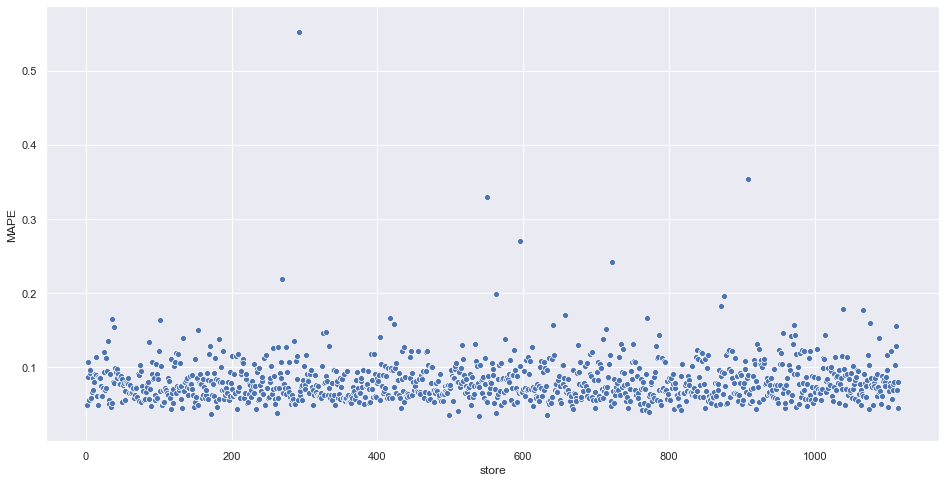

In [53]:
# scatterplot
plt.subplots(figsize=(16,8))

sns.scatterplot( x='store', y='MAPE', data=aux94);

## 9.2. Total Performance

In [58]:
# sum of predictions, worst and best scenario
df93 = aux94[['customers','predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0).reset_index().rename( columns={0:'total_customers'} )
df93['total_customers'] = df93['total_customers'].map( '{:,.2f}'.format )
df93

,index,total_customers
0,customers,"30,275,933.00"
1,predictions,"31,145,434.66"
2,worst_scenario,"31,082,863.02"
3,best_scenario,"31,208,006.30"


## 9.3. Machine Learning Performance

In [60]:
# lineplot customers prediction x target, error rate, error distribution, predictions x error scatter plot
# error
df9['error'] = df9['customers'] - df9['predictions']

# error rate
df9['error_rate'] = df9['predictions'] / df9['customers']

C:\Users\santo\Anaconda3\envs\ds-em-producao\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\santo\Anaconda3\envs\ds-em-producao\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


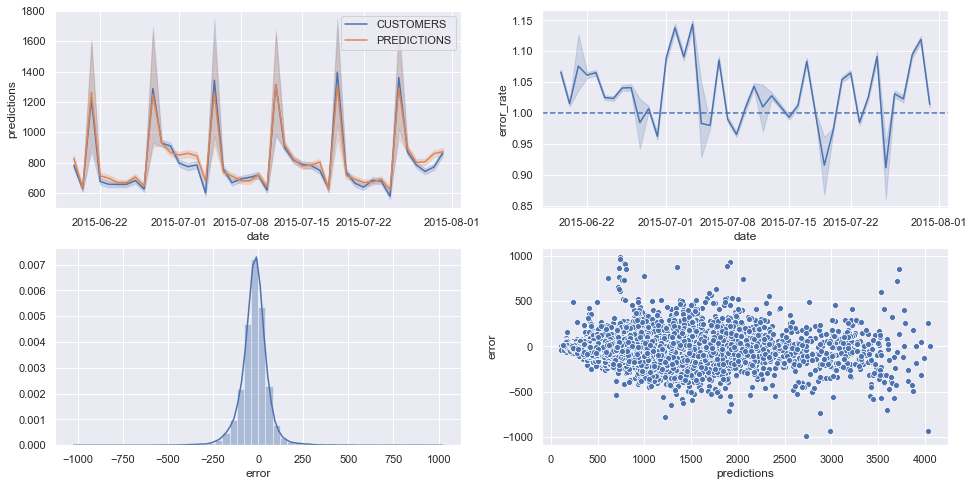

In [61]:
# set up plot
plt.subplots( 2, 2, figsize=(16,8) )

# lineplot date x customers x predictions
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='customers', data=df9, label='CUSTOMERS' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

# lineplot date x error_rate
plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9)
# add line in the lineplot
plt.axhline( 1, linestyle='--' )

# plot error distribution
plt.subplot( 2, 2, 3 )
sns.distplot(df9['error'])

# scatterplot predictions x error
plt.subplot( 2, 2, 4 )
sns.scatterplot( x='predictions', y='error', data=df9 )

## 9.4. Best and Worst MAPE

In [62]:
# best MAPE
aux94.sort_values('MAPE', ascending=True).head()

,store,customers,predictions,worst_scenario,best_scenario,MAE,MAPE
538,539,42099.0,41346.927561,41306.561192,41387.293930,40.366369,0.034511
631,632,34541.0,34761.044770,34728.224558,34793.864982,32.820212,0.035299
497,498,32226.0,32916.731672,32886.235452,32947.227891,30.496219,0.035682
171,172,31371.0,31886.458410,31854.249132,31918.667687,32.209277,0.037525
261,262,115365.0,114277.141899,114152.959500,114401.324299,124.182399,0.037936


In [63]:
# worst MAPE
aux94.sort_values('MAPE', ascending=False).head()

,store,customers,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,10720.0,12765.978048,12570.717116,12961.238979,195.260931,0.552153
908,909,23048.0,22515.598909,22205.885663,22825.312155,309.713246,0.353670
549,550,15287.0,20274.091485,20139.305229,20408.877742,134.786256,0.329565
594,595,60441.0,46486.341130,46054.386141,46918.296120,431.954990,0.270214
721,722,46509.0,57573.066461,57274.037638,57872.095284,299.028823,0.241820


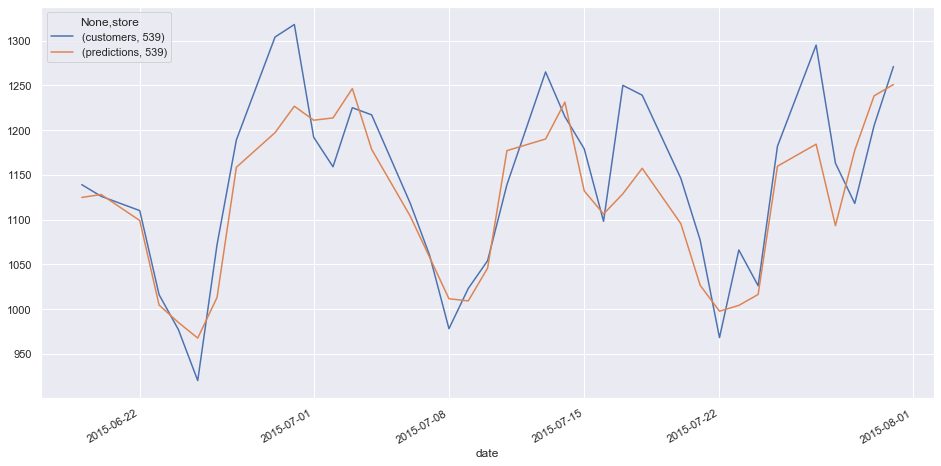

In [64]:
# sum of all customers and predictions by date and store
aux95 = df9[['customers', 'predictions', 'store', 'date']].groupby(['date', 'store']).sum().reset_index()

# lineplot store 539 - best prediction
aux96 = aux95[aux95['store']==539]
aux96.pivot( index='date', columns='store', values=['customers', 'predictions'] ).plot(figsize=(16,8))

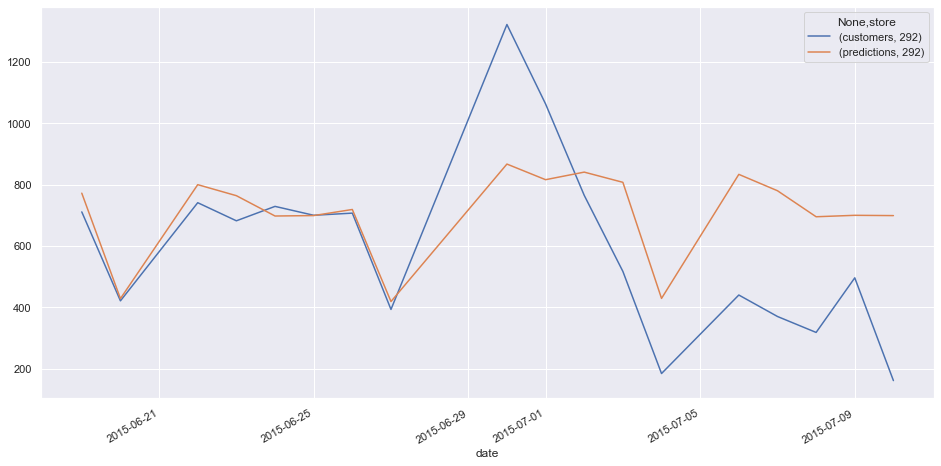

In [65]:
# lineplot store 292 - worst prediction
aux97 = aux95[aux95['store']==292]
aux97.pivot( index='date', columns='store', values=['customers', 'predictions'] ).plot(figsize=(16,8))

# 10.0. Customers Prediction on Test Data

In [66]:
# Load test data
df_test_raw = pd.read_csv('C:/Users/santo/repos/DataScience-Em-Producao/data/test.csv', low_memory=False)

# merge test and store datasets
df_test_store_raw = pd.merge(df_test_raw, df_stores_raw, on='Store', how='left')

## 10.1. Data Cleaning

In [67]:
# copy df_test_store_raw
df10 = df_test_store_raw.copy()

In [68]:
df10.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,3,4,2015-09-17,1.0,1,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
2,3,7,4,2015-09-17,1.0,1,0,0,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
3,4,8,4,2015-09-17,1.0,1,0,0,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
4,5,9,4,2015-09-17,1.0,1,0,0,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN


In [70]:
# drop Id column
df10 = df10.drop('Id',axis=1)

In [72]:
# Rename Columns
cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

# Apply snakecase to columns names
snakecase = lambda x: inflection.underscore( x )
cols = list(map(snakecase, cols_old))
df10.columns = cols

# Data Types
# transform column date to datetime
df10['date'] = pd.to_datetime(df1['date'])

# Fillout NA values
# competition_distance assumption: NA values mean a far competitor distance.
# therefore, the NA values will be replaced by 200000 (meters).
df10['competition_distance'] = df10['competition_distance'].apply( lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month and competition_open_since_year
# Assumption: fill NA with the corresponding month and year of the register.
df10['competition_open_since_month'] = df10.apply( lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)
df10['competition_open_since_year'] = df10.apply( lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2_since_week, promo2_since_year assumption: fill NA with the corresponding month and year of the register.
df10['promo2_since_week'] = df10.apply( lambda x: x['date'].isocalendar()[1] if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1)
df10['promo2_since_year'] = df10.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

# promo_interval - fill missing values with 0
df10['promo_interval'].fillna(0, inplace=True)

# Change Data Types
# change data types from float64 to int64 in order to allow further operations
df10['competition_open_since_month'] = df10['competition_open_since_month'].astype('int64')
df10['competition_open_since_year'] = df10['competition_open_since_year'].astype('int64')
df10['promo2_since_week'] = df10['promo2_since_week'].astype('int64')
df10['promo2_since_year'] = df10['promo2_since_year'].astype('int64')

## 10.2. Feature Engineering and Variables Filtering

In [75]:
# copy df10 dataframe
df12 = df10.copy()

In [76]:
# Feature Engineering
# create columns from date column
# year
df12['year'] = df12['date'].dt.year

# month
df12['month'] = df12['date'].dt.month

# day
df12['day'] = df12['date'].dt.day

# week of year
df12['week_of_year'] = df12['date'].dt.weekofyear

# year_week
df12['year_week'] = df12['date'].dt.strftime( '%Y-%W' )

# competition since - bring together competition_open_since_month and competition_open_since_year
df12['competition_since'] = df12.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1)

# calculate difference between date and competition_since. Divide by 30 to keep granularity
df12['competition_time_month'] = df12.apply( lambda x: (( x['date'] - x['competition_since'] )/30).days , axis=1 ).astype('int64')

# promo since
# 1. bring together promo2_since_year and promo2_since_week as a string
df12['promo_since'] = df12['promo2_since_year'].astype(str) + '-' + df12['promo2_since_week'].astype(str)
# 2. transform promo_since to date
df12['promo_since'] = df12['promo_since'].apply( lambda x: datetime.datetime.strptime( x+'-1', '%Y-%W-%w' ) - datetime.timedelta(days=7))
# 3. calculate difference between date and promo_since. Divide by 7 to keep weekly granularity
# promo_time_week
df12['promo_time_week'] = df12.apply( lambda x: (( x['date'] - x['promo_since'])/7 ).days, axis=1).astype('int64')

# assortment
# a = basic, b = extra, c = extended
df12['assortment'] = df12['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state_holiday
# a = public holiday, b = Easter holiday, c = Christmas, 0 = None = regular day
df12['state_holiday'] = df12['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [77]:
# Variables filtering
# closed stores (open = 0) means no sales. Therefore, it is not relevant for the sales forecast model. Open = 0 will be removed.
df12 = df12[(df12['open'] == 1)]

# open only has values = 1(the lines with zeros were deleted above), hence the column can be removed.
# promo_interval generated new columns in the feature engineering step and is no longer needed.
cols_drop = ['open', 'promo_interval']
df12 = df12.drop(cols_drop, axis=1)

## 10.3. Data Preparation

In [78]:
# copy df12
df13 = df12.copy()

### 10.3.1. Rescaling

In [79]:
# numerical variables: competition_distance, competition_time_month, promo_time_week, year
# competition_open_since_year, promo2_since_year

# 1. Robust Scaler - for variables with high outliers influence
rs = RobustScaler()
# competition_distance, competition_time_month and competition_open_since_year
# competition_distance
df13['competition_distance'] = rs.fit_transform( df13[['competition_distance']].values )
# competition_time_month
df13['competition_time_month'] = rs.fit_transform( df13[['competition_time_month']].values )
# competition_open_since_year
df13['competition_open_since_year'] = rs.fit_transform( df13[['competition_open_since_year']].values )

# 2. Min-Max Scaler - for variables with low outliers influence
mms = MinMaxScaler()
# competition_time_month, promo_time_week, year, promo2_since_year
# competition_time_month
df13['competition_time_month'] = mms.fit_transform( df13[['competition_time_month']].values )
# promo_time_week
df13['promo_time_week'] = mms.fit_transform( df13[['promo_time_week']].values )
# year
df13['year'] = mms.fit_transform( df13[['year']].values )
# promo2_since_year
df13['promo2_since_year'] = mms.fit_transform( df13[['promo2_since_year']].values )

### 10.3.2. Encoding

In [80]:
# categorical variables - state_holiday, store_type, assortment

# state_holiday - one hot encoding
df13 = pd.get_dummies(df13, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - label encoding
le = LabelEncoder()
df13['store_type'] = le.fit_transform( df13['store_type'] )

# assortment - Ordinal Encoding
assortment_dict = {'basic':1, 'extra': 2, 'extended': 3}
df13['assortment'] = df13['assortment'].map( assortment_dict )

### 10.3.3. Nature Transformation

In [81]:
# time variables - day_of_week, day, month, week_of_year, competition_open_since_month, promo2_since_week.

# day_of_week
df13['day_of_week_sin'] = df13['day_of_week'].apply( lambda x: np.sin( x * (2. * np.pi/7 ) ) )
df13['day_of_week_cos'] = df13['day_of_week'].apply( lambda x: np.cos( x * (2. * np.pi/7) ) )

# day
df13['day_sin'] = df13['day'].apply( lambda x: np.sin( x * (2. * np.pi/30 ) ) )
df13['day_cos'] = df13['day'].apply( lambda x: np.cos( x * (2. * np.pi/30 ) ) )

# month
df13['month_sin'] = df13['month'].apply( lambda x: np.sin( x * (2. * np.pi/12 ) ) )
df13['month_cos'] = df13['month'].apply( lambda x: np.cos( x * (2. * np.pi/12 ) ) )

# week_of_year
df13['week_of_year_sin'] = df13['week_of_year'].apply( lambda x: np.sin( x * (2. * np.pi/52 ) ) )
df13['week_of_year_cos'] = df13['week_of_year'].apply( lambda x: np.cos( x * (2. * np.pi/52 ) ) )

# competition_open_since_month
df13['competition_open_since_month_sin'] = df13['competition_open_since_month'].apply( lambda x: np.sin( x * (2. * np.pi/12 ) ) )
df13['competition_open_since_month_cos'] = df13['competition_open_since_month'].apply( lambda x: np.cos( x * (2. * np.pi/12 ) ) )

# promo2_since_week
df13['promo2_since_week_sin'] = df13['promo2_since_week'].apply( lambda x: np.sin( x * (2. * np.pi/52 ) ) )
df13['promo2_since_week_cos'] = df13['promo2_since_week'].apply( lambda x: np.cos( x * (2. * np.pi/52 ) ) )

### 10.3.4. Select Relevant Columns

In [82]:
# select relevant columns from boruta manual selection
df14 = df13[cols_selected_boruta]

## 10.4. Customers Prediction

In [83]:
# apply random forest regressor for customers prediction
customers_pred = rf.predict( df14 )

In [91]:
# join customers prediction in the test dataset (only for open stores)
df_test_customers = df_test_raw.copy()
df_test_customers = df_test_customers[df_test_customers['Open']==1]
df_test_customers['Customers'] = np.expm1(customers_pred)
df_test_customers.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Customers
0,1,1,4,2015-09-17,1.0,1,0,0,386.725235
1,2,3,4,2015-09-17,1.0,1,0,0,900.476589
2,3,7,4,2015-09-17,1.0,1,0,0,1246.178359
3,4,8,4,2015-09-17,1.0,1,0,0,845.095492
4,5,9,4,2015-09-17,1.0,1,0,0,573.770316


## 10.5. Prediction Export

In [92]:
# export test dataset to .csv file
df_test_customers.to_csv('C:/Users/santo/repos/DataScience-Em-Producao/data/test_customers.csv', index=False)